In [1]:
import numpy as np
import pandas as pd
from copy import deepcopy
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy.stats import norm
from itertools import repeat
from numpy.random import normal
from scipy.stats import ttest_1samp

In [2]:
import warnings
warnings.filterwarnings('ignore')

# Load and clean data

## Load states and abbreviation

In [3]:
states = pd.read_excel("./messy_data/states.xlsx")
states.drop(states.index[states.Abbreviation == "DC"], inplace=True)
states.columns = ["Jurisdiction", "Jurisdiction Abbreviation"]
states = states.append({"Jurisdiction" : "Federal", "Jurisdiction Abbreviation" : "FED"}, ignore_index=True)

In [4]:
states.head()

Jurisdiction Jurisdiction Abbreviation
0      Alabama                        AL
1       Alaska                        AK
2      Arizona                        AZ
3     Arkansas                        AR
4   California                        CA

## Load prisoner population data

In [5]:
malePrisonerPopulation = pd.read_excel("./messy_data/Prisoners under the jurisdiction of state or federal correctional authorities 1978-2016.xlsx", sheet_name="Male", header=9, nrows=54).dropna(1, "all").dropna(0)
femalePrisonerPopulation = pd.read_excel("./messy_data/Prisoners under the jurisdiction of state or federal correctional authorities 1978-2016.xlsx", sheet_name="Female", header=9, nrows=54).dropna(1, "all").dropna(0)

totalPrisonerPopulation = pd.read_excel("./messy_data/Prisoners under the jurisdiction of state or federal correctional authorities 1978-2016.xlsx", sheet_name="Total", header=9, nrows=54).dropna(1, "all").dropna(0)

In [6]:
def cleanPopulationTable(table, states):
    
    # add DC data to Federal, and delete it
    table.loc[table.Jurisdiction == "Federal"].iloc[:, 1:] = table.loc[table.Jurisdiction == "Federal"].iloc[:, 1:] + table.loc[table.Jurisdiction == "District of Columbia"].iloc[:, 1:].replace("--", 0)
    table.drop(table.index[table.Jurisdiction == "District of Columbia"], inplace=True)
    
    meltedTable = table.melt(id_vars = "Jurisdiction", var_name = "Year", value_name = "Population")
    
    table.set_index("Jurisdiction", inplace=True)
    table.columns = table.columns.astype(np.int)
    table.columns.name = "Year"
    table = table.astype(np.float)
    
    return table, meltedTable

In [7]:
malePrisonerPopulation, malePrisonerPopulation_melted = cleanPopulationTable(malePrisonerPopulation, states)
femalePrisonerPopulation, femalePrisonerPopulation_melted  = cleanPopulationTable(femalePrisonerPopulation, states)
totalPrisonerPopulation, totalPrisonerPopulation_melted = cleanPopulationTable(totalPrisonerPopulation, states)

In [8]:
totalPrisonerPopulation.head()

Year             1978     1979     1980     1981     1982     1983     1984  \
Jurisdiction                                                                  
Federal       29803.0  26371.0  24363.0  28133.0  29673.0  31926.0  34263.0   
Alabama        5625.0   5464.0   6543.0   7657.0   9233.0   9856.0  10482.0   
Alaska          712.0    760.0    822.0   1024.0   1322.0   1631.0   1967.0   
Arizona        3456.0   3749.0   4372.0   5223.0   6069.0   6889.0   7845.0   
Arkansas       2654.0   3042.0   2911.0   3328.0   3922.0   4246.0   4482.0   

Year             1985     1986     1987  ...      2007      2008      2009  \
Jurisdiction                             ...                                 
Federal       40223.0  44408.0  48300.0  ...  199618.0  201280.0  208118.0   
Alabama       11015.0  11710.0  12827.0  ...   29412.0   30508.0   31874.0   
Alaska         2329.0   2460.0   2528.0  ...    5167.0    5014.0    5285.0   
Arizona        8531.0   9434.0  10948.0  ...   37746.0   39502.0   40544.0   
Arkansas       4611.0   4701.0   5441.0  ...   14314.0   14716.0   15208.0   

Year              2010      2011      2012      2013      2014      2015  \
Jurisdiction                                                               
Federal       209771.0  216362.0  217815.0  215866.0  210567.0  196455.0   
Alabama        31764.0   32270.0   32431.0   32381.0   31771.0   30810.0   
Alaska          5391.0    5597.0    5633.0    5081.0    5794.0    5338.0   
Arizona        40209.0   40020.0   40080.0   41177.0   42259.0   42719.0   
Arkansas       16204.0   16108.0   14654.0   17235.0   17874.0   17707.0   

Year              2016  
Jurisdiction            
Federal       189192.0  
Alabama        28883.0  
Alaska          4434.0  
Arizona        42320.0  
Arkansas       17537.0  

[5 rows x 39 columns]

In [9]:
totalPrisonerPopulation_melted.head()

Jurisdiction  Year Population
0      Federal  1978      29803
1      Alabama  1978       5625
2       Alaska  1978        712
3      Arizona  1978       3456
4     Arkansas  1978       2654

## Load admission and release data

In [10]:
maleAdmission = pd.read_excel("./messy_data/admissions.xlsx", sheet_name="Male").dropna().replace("/", np.nan)
maleRelease = pd.read_excel("./messy_data/releases.xlsx", sheet_name="Male").dropna().replace("/", np.nan)

femaleAdmission = pd.read_excel("./messy_data/admissions.xlsx", sheet_name="Female").dropna().replace("/", np.nan)
femaleRelease = pd.read_excel("./messy_data/releases.xlsx", sheet_name="Female").dropna().replace("/", np.nan)

totalAdmission = pd.read_excel("./messy_data/admissions.xlsx", sheet_name="Total").dropna().replace("/", np.nan)
totalRelease = pd.read_excel("./messy_data/releases.xlsx", sheet_name="Total").dropna().replace("/", np.nan)

In [11]:
def cleanCountTable(table, states, tableType):
    
    table.replace([".", "/"], [np.nan, np.nan], inplace=True)
    
    for i, row in table.iterrows():
        if row.isnull().any():
            table.loc[i, 1 :] = pd.to_numeric(row.iloc[1 :]).interpolate()
    
    # add DC data to Federal, and delete it
    table.loc[table.Jurisdiction == "Federal"].iloc[:, 1:] = table.loc[table.Jurisdiction == "Federal"].iloc[:, 1:] + table.loc[table.Jurisdiction == "District of Columbia"].iloc[:, 1:].replace("--", 0)
    table.drop(table.index[table.Jurisdiction == "District of Columbia"], inplace=True)
    
    meltedTable = table.melt(id_vars = "Jurisdiction", var_name = "Year", value_name = tableType)
    
    table.set_index("Jurisdiction", inplace=True)
    table.columns = table.columns.astype(np.int)
    table.columns.name = "Year"
    table = table.astype(np.float)
    
    return table, meltedTable

In [12]:
maleAdmission, maleAdmission_melted = cleanCountTable(maleAdmission, states, "Admission")
maleRelease, maleRelease_melted = cleanCountTable(maleRelease, states, "Release")

femaleAdmission, femaleAdmission_melted = cleanCountTable(femaleAdmission, states, "Admission")
femaleRelease, femaleRelease_melted = cleanCountTable(femaleRelease, states, "Release")

totalAdmission, totalAdmission_melted = cleanCountTable(totalAdmission, states, "Admission")
totalRelease, totalRelease_melted = cleanCountTable(totalRelease, states, "Release")

In [13]:
totalAdmission.head()

Year             1978     1979     1980     1981     1982     1983     1984  \
Jurisdiction                                                                  
Federal       14724.0  14120.0  12598.0  12830.0  14818.0  16745.0  16013.0   
Alabama        2572.0   2597.0   3766.0   4025.0   4425.0   4605.0   4701.0   
Alaska          258.0    311.0    459.0    461.0    541.0    711.0    727.0   
Arizona        1620.0   1641.0   2082.0   2759.0   2910.0   3288.0   3386.0   
Arkansas       1958.0   2189.0   2311.0   2419.0   2323.0   2173.0   2179.0   

Year             1985     1986     1987  ...          2007          2008  \
Jurisdiction                             ...                               
Federal       17916.0  18501.0  18709.0  ...  53618.000000  53662.000000   
Alabama        4370.0   3962.0   4543.0  ...  10708.000000  11037.000000   
Alaska          875.0   1097.0    952.0  ...   2716.428571   2694.285714   
Arizona        3989.0   4515.0   5370.0  ...  14046.000000  14867.000000   
Arkansas       2301.0   2280.0   3152.0  ...   6651.000000   7017.000000   

Year                  2009     2010     2011     2012     2013     2014  \
Jurisdiction                                                              
Federal       56153.000000  54121.0  60634.0  55938.0  53664.0  50865.0   
Alabama       13093.000000  11881.0  11387.0  11203.0  11265.0  10912.0   
Alaska         2672.142857   2650.0   3789.0   3906.0   3906.0   3846.0   
Arizona       14526.000000  13249.0  13030.0  12970.0  13538.0  14439.0   
Arkansas       7383.000000   7603.0   7059.0   5782.0   8987.0   9435.0   

Year             2015     2016  
Jurisdiction                    
Federal       46912.0  44682.0  
Alabama       10451.0  10749.0  
Alaska         4271.0   1804.0  
Arizona       14670.0  13663.0  
Arkansas       9351.0   9911.0  

[5 rows x 39 columns]

In [14]:
totalAdmission_melted.head()

Jurisdiction  Year Admission
0      Federal  1978     14724
1      Alabama  1978      2572
2       Alaska  1978       258
3      Arizona  1978      1620
4     Arkansas  1978      1958

## Load regions and divisions
## Aggregate and sum population, admission and release according to regions and divisions

In [15]:
regions = pd.read_excel("./messy_data/state_region.xlsx")
regions.drop(regions.index[regions.State == "District of Columbia"], inplace=True)

In [16]:
regions.head()

State     Division     Region
0    Connecticut  New England  Northeast
1          Maine  New England  Northeast
2  Massachusetts  New England  Northeast
3  New Hampshire  New England  Northeast
4   Rhode Island  New England  Northeast

In [17]:
def aggregateRegionalPopulationSum(meltedTable, regions):
    
    meltedTable = regions.merge(meltedTable, left_on="State", right_on="Jurisdiction", how="right")
    temp_index = meltedTable["Jurisdiction"] == "Federal"
    meltedTable.loc[temp_index, "Region"] = "Federal"
    meltedTable.loc[temp_index, "Division"] = "Federal"
    
    regionSum = meltedTable.groupby(["Year", "Region"]).Population.sum().unstack(0)
    divisionSum = meltedTable.groupby(["Year", "Region", "Division"]).Population.sum().unstack(0)
    
    return regionSum, divisionSum

In [18]:
malePrisonerPopulationRegionSum, malePrisonerPopulationDivisionSum = aggregateRegionalPopulationSum(malePrisonerPopulation_melted, regions)
femalePrisonerPopulationRegionSum, femalePrisonerPopulationDivisionSum = aggregateRegionalPopulationSum(femalePrisonerPopulation_melted, regions)
totalPrisonerPopulationRegionSum, totalPrisonerPopulationDivisionSum = aggregateRegionalPopulationSum(totalPrisonerPopulation_melted, regions)

In [19]:
totalPrisonerPopulationRegionSum

Year           1978      1979      1980      1981      1982      1983  \
Region                                                                  
Federal     29803.0   26371.0   24363.0   28133.0   29673.0   31926.0   
Midwest     61657.0   63615.0   66211.0   73216.0   78312.0   81853.0   
Northeast   42236.0   43726.0   45796.0   53908.0   59325.0   64640.0   
South      128865.0  133455.0  143213.0  156038.0  177370.0  181395.0   
West        41851.0   44317.0   47093.0   55156.0   65045.0   72697.0   

Year           1984      1985      1986      1987  ...      2007      2008  \
Region                                             ...                       
Federal     34263.0   40223.0   44408.0   48300.0  ...  199618.0  201280.0   
Midwest     85664.0   95577.0  103011.0  111123.0  ...  263039.0  264314.0   
Northeast   70498.0   75591.0   82364.0   91210.0  ...  179001.0  178642.0   
South      187744.0  195950.0  207673.0  215180.0  ...  638228.0  646030.0   
West        79312.0   88762.0  100898.0  111626.0  ...  316949.0  318016.0   

Year           2009      2010      2011      2012      2013      2014  \
Region                                                                  
Federal    208118.0  209771.0  216362.0  217815.0  215866.0  210567.0   
Midwest    261615.0  263485.0  262544.0  264758.0  267095.0  267116.0   
Northeast  177361.0  173912.0  170944.0  167648.0  166567.0  162694.0   
South      651504.0  654653.0  653305.0  641155.0  644421.0  637309.0   
West       316889.0  311982.0  295813.0  279021.0  283001.0  284633.0   

Year           2015      2016  
Region                         
Federal    196455.0  189192.0  
Midwest    263996.0  258805.0  
Northeast  157986.0  154166.0  
South      630236.0  624803.0  
West       277930.0  278431.0  

[5 rows x 39 columns]

In [20]:
totalPrisonerPopulationDivisionSum

Year                             1978     1979     1980     1981     1982  \
Region    Division                                                          
Federal   Federal             29803.0  26371.0  24363.0  28133.0  29673.0   
Midwest   East North Central  47664.0  49641.0  51175.0  56860.0  60027.0   
          West North Central  13993.0  13974.0  15036.0  16356.0  18285.0   
Northeast Mid-Atlantic        34142.0  34480.0  35870.0  41870.0  46644.0   
          New England          8094.0   9246.0   9926.0  12038.0  12681.0   
South     East South Central  17746.0  19292.0  21055.0  24171.0  26617.0   
          South Atlantic      72413.0  72731.0  75670.0  82341.0  93252.0   
          West South Central  38706.0  41432.0  46488.0  49526.0  57501.0   
West      Mountain            11721.0  12548.0  13141.0  15092.0  17458.0   
          Pacific             30130.0  31769.0  33952.0  40064.0  47587.0   

Year                             1983     1984      1985      1986      1987  \
Region    Division                                                             
Federal   Federal             31926.0  34263.0   40223.0   44408.0   48300.0   
Midwest   East North Central  62253.0  64639.0   72734.0   78572.0   84939.0   
          West North Central  19600.0  21025.0   22843.0   24439.0   26184.0   
Northeast Mid-Atlantic        51469.0  56562.0   60069.0   65670.0   73078.0   
          New England         13171.0  13936.0   15522.0   16694.0   18132.0   
South     East South Central  28416.0  28724.0   29515.0   31336.0   33783.0   
          South Atlantic      93182.0  96325.0  102072.0  109094.0  112121.0   
          West South Central  59797.0  62695.0   64363.0   67243.0   69276.0   
West      Mountain            19383.0  21138.0   22869.0   25401.0   28271.0   
          Pacific             53314.0  58174.0   65893.0   75497.0   83355.0   

Year                          ...      2007      2008      2009      2010  \
Region    Division            ...                                           
Federal   Federal             ...  199618.0  201280.0  208118.0  209771.0   
Midwest   East North Central  ...  197054.0  197599.0  194218.0  195052.0   
          West North Central  ...   65985.0   66715.0   67397.0   68433.0   
Northeast Mid-Atlantic        ...  135416.0  135515.0  135498.0  132927.0   
          New England         ...   43585.0   43127.0   41863.0   40985.0   
South     East South Central  ...  100567.0  102196.0  101959.0  100826.0   
          South Atlantic      ...  289414.0  293571.0  298505.0  298277.0   
          West South Central  ...  248247.0  250263.0  251040.0  255550.0   
West      Mountain            ...   99802.0  101284.0  101802.0  102506.0   
          Pacific             ...  217147.0  216732.0  215087.0  209476.0   

Year                              2011      2012      2013      2014  \
Region    Division                                                     
Federal   Federal             216362.0  217815.0  215866.0  210567.0   
Midwest   East North Central  193894.0  195291.0  196525.0  195055.0   
          West North Central   68650.0   69467.0   70570.0   72061.0   
Northeast Mid-Atlantic        130848.0  128560.0  127424.0  124802.0   
          New England          40096.0   39088.0   39143.0   37892.0   
South     East South Central  103680.0  105271.0  103901.0  100990.0   
          South Atlantic      295606.0  289461.0  288159.0  286722.0   
          West South Central  254019.0  246423.0  252361.0  249597.0   
West      Mountain            102253.0  100912.0  102806.0  103693.0   
          Pacific             193560.0  178109.0  180195.0  180940.0   

Year                              2015      2016  
Region    Division                                
Federal   Federal             196455.0  189192.0  
Midwest   East North Central  191431.0  185877.0  
          West North Central   72565.0   72928.0  
Northeast Mid-Atlantic        122074.0  119746.0  
          New Engl

In [21]:
def aggregateRegionalCountSum(meltedTable, regions, tableType):
    
    meltedTable = regions.merge(meltedTable, left_on="State", right_on="Jurisdiction", how="right")
    temp_index = meltedTable["Jurisdiction"] == "Federal"
    meltedTable.loc[temp_index, "Region"] = "Federal"
    meltedTable.loc[temp_index, "Division"] = "Federal"
    
    regionSum = meltedTable.groupby(["Year", "Region"])[tableType].sum().unstack(0)
    divisionSum = meltedTable.groupby(["Year", "Region", "Division"])[tableType].sum().unstack(0)
    
    return regionSum, divisionSum

In [22]:
maleAdmissionRegionSum, maleAdmissionDivisionSum = aggregateRegionalCountSum(maleAdmission_melted, regions, "Admission")
maleReleaseRegionSum, maleReleaseDivisionSum = aggregateRegionalCountSum(maleRelease_melted, regions, "Release")

femaleAdmissionRegionSum, femaleAdmissionDivisionSum = aggregateRegionalCountSum(femaleAdmission_melted, regions, "Admission")
femaleReleaseRegionSum, femaleReleaseDivisionSum = aggregateRegionalCountSum(femaleRelease_melted, regions, "Release")

totalAdmissionRegionSum, totalAdmissionDivisionSum = aggregateRegionalCountSum(totalAdmission_melted, regions, "Admission")
totalReleaseRegionSum, totalReleaseDivisionSum = aggregateRegionalCountSum(femaleRelease_melted, regions, "Release")

In [23]:
totalAdmissionRegionSum

Year          1978     1979     1980     1981     1982     1983     1984  \
Region                                                                     
Federal    14724.0  14120.0  12598.0  12830.0  14818.0  16745.0  16013.0   
Midwest    31416.0  32346.0  36629.0  43823.0  43159.0  45160.0  44242.0   
Northeast  19791.0  21522.0  23380.0  27124.0  28009.0  31880.0  31584.0   
South      60432.0  65637.0  71934.0  82751.0  93346.0  99019.0  94429.0   
West       22888.0  26345.0  26069.0  31986.0  37021.0  43539.0  46261.0   

Year           1985      1986      1987  ...           2007           2008  \
Region                                   ...                                 
Federal     17916.0   18501.0   18709.0  ...   53618.000000   53662.000000   
Midwest     47418.0   50638.0   53616.0  ...  148972.000000  146294.000000   
Northeast   33068.0   37080.0   40271.0  ...   73283.000000   70760.000000   
South      101381.0  114078.0  129183.0  ...  258223.000000  261312.000000   
West        56490.0   69473.0   81614.0  ...  211495.428571  210668.285714   

Year                2009      2010      2011      2012      2013      2014  \
Region                                                                       
Federal     56153.000000   54121.0   60634.0   55938.0   53664.0   50865.0   
Midwest    147553.000000  140904.0  132318.0  132660.0  136633.0  132188.0   
Northeast   67642.000000   66844.0   65710.0   65149.0   66312.0   63847.0   
South      255706.000000  251959.0  248187.0  249838.0  260444.0  263452.0   
West       204304.142857  189970.0  164702.0  104857.0  112909.0  115744.0   

Year           2015      2016  
Region                         
Federal     46912.0   44682.0  
Midwest    128837.0  125453.0  
Northeast   62160.0   61727.0  
South      258243.0  260225.0  
West       112166.0  113913.0  

[5 rows x 39 columns]

In [24]:
totalAdmissionDivisionSum

Year                             1978     1979     1980     1981     1982  \
Region    Division                                                          
Federal   Federal             14724.0  14120.0  12598.0  12830.0  14818.0   
Midwest   East North Central  23933.0  24807.0  28339.0  34316.0  32938.0   
          West North Central   7483.0   7539.0   8290.0   9507.0  10221.0   
Northeast Mid-Atlantic        15376.0  16020.0  17508.0  21340.0  21665.0   
          New England          4415.0   5502.0   5872.0   5784.0   6344.0   
South     East South Central   9111.0  10817.0  11860.0  14307.0  14296.0   
          South Atlantic      32121.0  34344.0  36832.0  43694.0  48398.0   
          West South Central  19200.0  20476.0  23242.0  24750.0  30652.0   
West      Mountain             6348.0   6293.0   6830.0   8955.0   9519.0   
          Pacific             16540.0  20052.0  19239.0  23031.0  27502.0   

Year                             1983     1984     1985     1986     1987  \
Region    Division                                                          
Federal   Federal             16745.0  16013.0  17916.0  18501.0  18709.0   
Midwest   East North Central  34566.0  33460.0  35610.0  37708.0  39523.0   
          West North Central  10594.0  10782.0  11808.0  12930.0  14093.0   
Northeast Mid-Atlantic        25482.0  25091.0  26243.0  30002.0  32194.0   
          New England          6398.0   6493.0   6825.0   7078.0   8077.0   
South     East South Central  15104.0  14910.0  14882.0  13656.0  13031.0   
          South Atlantic      50438.0  45679.0  49554.0  56473.0  67436.0   
          West South Central  33477.0  33840.0  36945.0  43949.0  48716.0   
West      Mountain            10603.0  11127.0  12479.0  13747.0  14773.0   
          Pacific             32936.0  35134.0  44011.0  55726.0  66841.0   

Year                          ...           2007           2008  \
Region    Division            ...                                 
Federal   Federal             ...   53618.000000   53662.000000   
Midwest   East North Central  ...  105930.000000  103770.000000   
          West North Central  ...   43042.000000   42524.000000   
Northeast Mid-Atlantic        ...   57748.000000   55797.000000   
          New England         ...   15535.000000   14963.000000   
South     East South Central  ...   50351.000000   47414.000000   
          South Atlantic      ...  105353.000000  109602.000000   
          West South Central  ...  102519.000000  104296.000000   
West      Mountain            ...   45848.000000   44951.000000   
          Pacific             ...  165647.428571  165717.285714   

Year                                   2009      2010      2011      2012  \
Region    Division                                                          
Federal   Federal              56153.000000   54121.0   60634.0   55938.0   
Midwest   East North Central  106471.000000  100191.0   91282.0   91188.0   
          West North Central   41082.000000   40713.0   41036.0   41472.0   
Northeast Mid-Atlantic         53223.000000   52448.0   51542.0   51533.0   
          New England          14419.000000   14396.0   14168.0   13616.0   
South     East South Central   49257.000000   48742.0   49559.0   49083.0   
          South Atlantic      104517.000000   96437.0   94508.0   94573.0   
          West South Central  101932.000000  106780.0  104120.0  106182.0   
West      Mountain             47189.000000   44261.0   41230.0   41525.0   
          Pacific             157115.142857  145709.0  123472.0   63332.0   

Year                              2013      2014      2015      2016  
Region    Division                                                    
Federal   Federal              53664.0   50865.0   46912.0   44682.0  
Midwest   East North Central   93598.0   88921.0   85093.0   80226.0  
          West North Central   43035.0   43267.0   43744.0   45227.0  
Northeast Mid-Atlantic         52997.0   50913.0   49808.0   5024

## Load capacity data

In [25]:
capacity = pd.read_excel("./messy_data/facility capacity 2016.xlsx").replace(["…", "/"], np.nan)
capacity = capacity.set_index("Jurisdiction").max(axis=1)
capacity.dropna(inplace=True)
capacity = capacity.astype(np.float)
capacity.name = "Capacity"
capacity.head()

Jurisdiction
Federal     135334.0
Alabama      25784.0
Alaska        4838.0
Arizona      44831.0
Arkansas     16449.0
Name: Capacity, dtype: float64

In [26]:
capacitySum = regions.merge(capacity, left_on="State",right_on="Jurisdiction")
capacitySum.columns = ["Jurisdiction", "Division", "Region", "Capacity"]
capacitySum.iloc[-1] = ["Federal", "Federal", "Federal", capacity["Federal"]]
capacitySum = capacitySum[["Region", "Division", "Jurisdiction", "Capacity"]]

In [27]:
capacityRegionSum = capacitySum.groupby(["Region"]).Capacity.sum()
capacityDivisionSum = capacitySum.groupby(["Region", "Division"]).Capacity.sum()

In [28]:
capacityRegionSum

Region
Federal      135334.0
Midwest      194841.0
Northeast    145842.0
South        561824.0
West         248834.0
Name: Capacity, dtype: float64

In [29]:
capacityDivisionSum

Region     Division          
Federal    Federal               135334.0
Midwest    East North Central    126930.0
           West North Central     67911.0
Northeast  Mid-Atlantic          122113.0
           New England            23729.0
South      East South Central     77048.0
           South Atlantic        270211.0
           West South Central    214565.0
West       Mountain               98390.0
           Pacific               150444.0
Name: Capacity, dtype: float64

## Load average sentencing data

In [30]:
annualSentence = pd.read_excel("./messy_data/national sentencing.xlsx").iloc[:, [0,1]]
annualSentence.columns = ["Year", "Sentence"]
annualSentence.set_index("Year", inplace=True)
annualSentence = annualSentence.iloc[:-1,0]

Text(0.5, 1.0, 'Average National Sentencing')

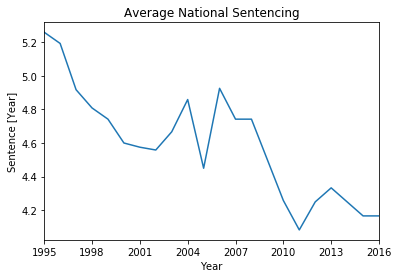

In [31]:
annualSentence.plot()
plt.xticks(np.array(range(1995, 2017, 3)))
plt.ylabel("Sentence [Year]")
plt.title("Average National Sentencing")

# Forecast

In [32]:
def extractAreaPopulationCount(table, area, tableType="Population", year_begin=1978,year_end=2016):
    # Extract a series of population, admission or release data for an area (state, region or division)
    # area is a pandas index
    
    data = table.loc[area]
         
    data = data[np.logical_and(data.index <= year_end, data.index >= year_begin)]
    data.name = tableType
    data.index.name="Year"
    
    return data

In [33]:
def propogateMu(past_mu,past_p, current_p, current_a,current_r, current_y):
    # State propogation function derived from the equilibrium of population * mu
    
    return (past_p * (past_mu - 1) + 0.5 * current_r + current_a * (current_y - 0.5)) / current_p

In [34]:
def solveMu(initialMu,initialPopulation, population, admission,release, anualSentence):
    # Given the initial state of mu and populatin,
    # this function can calculate the evolution of mu
    # according to the revolution of population, admission, release, and average sentence
    
    mu = population * 0
    mu.name = "Mu"

    for i, p in enumerate(population):
    
        if i == 0:
            past_p = initialPopulation
            past_mu = initialMu

        mu.iloc[i] = propogateMu(past_mu, past_p, population.iloc[i], admission.iloc[i],release.iloc[i], anualSentence.iloc[i])
        
        past_mu = mu.iloc[i]
        past_p = population.iloc[i]
        
    mu[1994] = initialMu
    mu = mu.sort_index()
    
    return mu

In [35]:
def estimateSigmaOfNormalCDF(x,F, mu):
    # Given x and F -- CDF at x of a normal distribution with center of mu,
    # this function estimate the square root of variance
    
    # This function can take vetor input
    
    # we have function F(x) as the CDF of N(mu, sigma^2)
    # given function Phi(x) as the CDF of N(0, 1)
    # F(x) = Phi((x - mu) / sigma)
    
    # the reverse function of Phi is norm.ppf()
    return (x - mu) / norm.ppf(F) 

In [36]:
def estimateSigma(population, release, mu): 
    
    mu = mu.values[: -1]
    p = population.values[: -1]
    r = release.values

    F = r / p
    sigma = estimateSigmaOfNormalCDF(1,F, mu)
    sigma = sigma[sigma >= 0]
    
    return sigma.mean()

In [37]:
def sampleFutureAdmissionSentence(sampleMean,sampleSD, year_end, dataType):
    
    years = range(2017, year_end + 1)
    simulated = normal(sampleMean,sampleSD, len(years))
    simulated[simulated <= 0.] = sampleMean
    if dataType == "Admission":
        simulated = np.round(simulated)
    
    simulated = pd.Series(simulated, index=years, name=dataType)
    simulated.index.name = "Year"
    
    return simulated

In [38]:
def propogateState(past_mu,past_p, current_a,current_y, epsilon_sd, sigma):
    # State propogation function
    # This function estimates release as PDF of a normal distribution with mu as the center.
    # The population was propogated as increment of difference between admission and release, plus proportional error
    
    if np.isnan(sigma):
        current_r = (- past_p + current_a * (current_y - 0.5 + past_mu)) / (past_mu - 0.5)
        # This dynamics tries to stablize mu
    else:
        current_r = np.round(norm(past_mu, sigma).cdf(1) * past_p)
    current_p = np.round(past_p + current_a - current_r + normal(scale=epsilon_sd) * past_p)
    current_mu = propogateMu(past_mu,past_p, current_p, current_a,current_r, current_y)
    
    return current_mu, current_p, current_r

In [39]:
def solvePopulation(initialMu,initialPopulation, futureAdmission,futureSentence, epsilon_sd, sigma):
    
    futurePopulation = futureAdmission * 0
    futurePopulation.name = "Population"
    
    futureRelease = futureAdmission * 0
    futureRelease.name = "Release"
    
    futureMu = futureSentence * 0
    futureMu.name = "Mu"
    
    for i, p in enumerate(futurePopulation):
        
        if i == 0:
            past_mu = initialMu
            past_p = initialPopulation
            
        futureMu.iloc[i], futurePopulation.iloc[i], futureRelease.iloc[i] = propogateState(past_mu,past_p, futureAdmission.iloc[i],futureSentence.iloc[i], epsilon_sd, sigma)
        
        past_mu = futureMu.iloc[i]
        past_p = futurePopulation.iloc[i]
        
    return futureMu, futurePopulation, futureRelease

In [40]:
def modelAndProject_NSamples_OneArea(populationTable, admissionTable,releaseTable, area, annualSentence, initialMu, projectionYear, N):
    
    # Note: the population, admission and release data range -- 1978-2016
    # the anual sentencing data range -- 1995-2016
    # N is the number of samples to draw for prediction
    # initialMu is the mu for 1994
    # projectionYear is the end of projection

    
    # Estimate error term of population increment
    
    population = extractAreaPopulationCount(populationTable, area, "Population")
    admission = extractAreaPopulationCount(admissionTable, area, "Admission")
    release = extractAreaPopulationCount(releaseTable, area, "Release")
    # data range 1978-2017
    
    epsilon = (population.diff() - admission + release).values[1:] / population.values[:-1]
    epsilon_sd = epsilon.std()
    
    # Model state propogation
    
    modernPopulation = population.loc[1995 :]
    modernAdmission = admission.loc[1995 :]
    modernRelease = release.loc[1995 :]
    # data range 1995-2016
    
    # estimate mu[t]
    initialPopulation = population[1994] # use 1994 for initial population
    mu = solveMu(initialMu,initialPopulation, modernPopulation, modernAdmission,modernRelease, annualSentence)
    # solveMu already concates initial state of mu to the output
    
    # estimate sigma
    modernPopulation = population.loc[1994 :]
    # include the initial state of population

    sigma = estimateSigma(modernPopulation, modernRelease, mu)
    
    # Project to from 2017 to projectionYear
    
    # Model and sample N sets of future admission and sentence
    
    admissionSD = modernAdmission.std()
    futureAdmissions = [sampleFutureAdmissionSentence(modernAdmission.iloc[-1],admissionSD, 2050, "Admission") for i in range(N)]

    sentenceSD = annualSentence.std()
    futureSentences = [sampleFutureAdmissionSentence(annualSentence.iloc[-1],sentenceSD, 2050, "Sentence") for i in range(N)]
    
    # Project future mu, population and release
    
    futureMus, futurePopulations, futureReleases = zip(*map(solvePopulation, repeat(mu.iloc[-1]),repeat(modernPopulation.iloc[-1]), futureAdmissions,futureSentences, repeat(epsilon_sd), repeat(sigma)))
    
    futurePopulations = pd.concat(futurePopulations, axis=1)
    futureAdmissions = pd.concat(futureAdmissions, axis=1)
    futureReleases = pd.concat(futureReleases, axis=1)
    
    return futurePopulations, futureAdmissions,futureReleases

## Projection of prisoner population

In [41]:
def collapseSamples(sampleTable, area):
    
    sampleMean = sampleTable.mean(axis=1)
    sampleMean.name = area
    
    sampleSD = sampleTable.std(axis=1)
    sampleSD.name = area
    
    return sampleMean, sampleSD
    

In [42]:
def modelAndProjectPopulation_NSamples(populationTable, admissionTable,releaseTable, annualSentence, initialMu, projectionYear, N):
    
    areas = populationTable.index
    
    futurePopulationMeans = []
    futurePopulationSDs = []
    
    futureAdmissionMeans = []
    futureAdmissionSDs = []
    
    futureReleaseMeans = []
    futureReleaseSDs = []
    
    for area in areas:
        
        futurePopulations, futureAdmissions,futureReleases = modelAndProject_NSamples_OneArea(populationTable, admissionTable,releaseTable, area, annualSentence, initialMu, projectionYear, N)
        
        futurePopulationMean, futurePopulationSD = collapseSamples(futurePopulations, area)
        futurePopulationMeans.append(futurePopulationMean)
        futurePopulationSDs.append(futurePopulationSD)
        
        futureAdmissionMean, futureAdmissionSD = collapseSamples(futureAdmissions, area)
        futureAdmissionMeans.append(futureAdmissionMean)
        futureAdmissionSDs.append(futureAdmissionSD)
        
        futureReleaseMean, futureReleaseSD = collapseSamples(futureReleases, area)
        futureReleaseMeans.append(futureReleaseMean)
        futureReleaseSDs.append(futureReleaseSD)
        
    futurePopulationMeans = pd.concat(futurePopulationMeans, axis=1).transpose()
    futureAdmissionMeans = pd.concat(futureAdmissionMeans, axis=1).transpose()
    futureReleaseMeans = pd.concat(futureReleaseMeans, axis=1).transpose()
    
    futurePopulationSDs = pd.concat(futurePopulationSDs, axis=1).transpose()
    futureAdmissionSDs = pd.concat(futureAdmissionSDs, axis=1).transpose()
    futureReleaseSDs = pd.concat(futureReleaseSDs, axis=1).transpose()
        
    return futurePopulationMeans,futurePopulationSDs, futureAdmissionMeans,futureAdmissionSDs, futureReleaseMeans,futureReleaseSDs


In [43]:
plt.rcParams["figure.figsize"] = (10,5)

In [44]:
maleFuturePopulationMean_5,maleFuturePopulationSD_5, maleFutureAdmissionMean_5,maleFutureAdmissionSD_5, maleFutureReleaseMean_5,maleFutureReleaseSD_5 = modelAndProjectPopulation_NSamples(malePrisonerPopulation, maleAdmission,maleRelease, annualSentence, 5, 2050, 250)
maleFuturePopulationMean_10,maleFuturePopulationSD_10, maleFutureAdmissionMean_10,maleFutureAdmissionSD_10, maleFutureReleaseMean_10,maleFutureReleaseSD_10 = modelAndProjectPopulation_NSamples(malePrisonerPopulation, maleAdmission,maleRelease, annualSentence, 10, 2050, 250)
maleFuturePopulationMean_20,maleFuturePopulationSD_20, maleFutureAdmissionMean_20,maleFutureAdmissionSD_20, maleFutureReleaseMean_20,maleFutureReleaseSD_20 = modelAndProjectPopulation_NSamples(malePrisonerPopulation, maleAdmission,maleRelease, annualSentence, 20, 2050, 250)
maleFuturePopulationMean_40,maleFuturePopulationSD_40, maleFutureAdmissionMean_40,maleFutureAdmissionSD_40, maleFutureReleaseMean_40,maleFutureReleaseSD_40 = modelAndProjectPopulation_NSamples(malePrisonerPopulation, maleAdmission,maleRelease, annualSentence, 40, 2050, 250)

femaleFuturePopulationMean_5,femaleFuturePopulationSD_5, femaleFutureAdmissionMean_5,femaleFutureAdmissionSD_5, femaleFutureReleaseMean_5,femaleFutureReleaseSD_5 = modelAndProjectPopulation_NSamples(femalePrisonerPopulation, femaleAdmission,femaleRelease, annualSentence, 5, 2050, 250)
femaleFuturePopulationMean_10,femaleFuturePopulationSD_10, femaleFutureAdmissionMean_10,femaleFutureAdmissionSD_10, femaleFutureReleaseMean_10,femaleFutureReleaseSD_10 = modelAndProjectPopulation_NSamples(femalePrisonerPopulation, femaleAdmission,femaleRelease, annualSentence, 10, 2050, 250)
femaleFuturePopulationMean_20,femaleFuturePopulationSD_20, femaleFutureAdmissionMean_20,femaleFutureAdmissionSD_20, femaleFutureReleaseMean_20,femaleFutureReleaseSD_20 = modelAndProjectPopulation_NSamples(femalePrisonerPopulation, femaleAdmission,femaleRelease, annualSentence, 20, 2050, 250)
femaleFuturePopulationMean_40,femaleFuturePopulationSD_40, femaleFutureAdmissionMean_40,femaleFutureAdmissionSD_40, femaleFutureReleaseMean_40,femaleFutureReleaseSD_40 = modelAndProjectPopulation_NSamples(femalePrisonerPopulation, femaleAdmission,femaleRelease, annualSentence, 40, 2050, 250)

In [45]:
maleFuturePopulationRegionSumMean_5,maleFuturePopulationRegionSumSD_5, maleFutureAdmissionRegionSumMean_5,maleFutureAdmissionRegionSumSD_5, maleFutureReleaseRegionSumMean_5,maleFutureReleaseRegionSumSD_5 = modelAndProjectPopulation_NSamples(malePrisonerPopulationRegionSum, maleAdmissionRegionSum,maleReleaseRegionSum, annualSentence, 5, 2050, 250)
maleFuturePopulationRegionSumMean_10,maleFuturePopulationRegionSumSD_10, maleFutureAdmissionRegionSumMean_10,maleFutureAdmissionRegionSumSD_10, maleFutureReleaseRegionSumMean_10,maleFutureReleaseRegionSumSD_10 = modelAndProjectPopulation_NSamples(malePrisonerPopulationRegionSum, maleAdmissionRegionSum,maleReleaseRegionSum, annualSentence, 10, 2050, 250)
maleFuturePopulationRegionSumMean_20,maleFuturePopulationRegionSumSD_20, maleFutureAdmissionRegionSumMean_20,maleFutureAdmissionRegionSumSD_20, maleFutureReleaseRegionSumMean_20,maleFutureReleaseRegionSumSD_20 = modelAndProjectPopulation_NSamples(malePrisonerPopulationRegionSum, maleAdmissionRegionSum,maleReleaseRegionSum, annualSentence, 20, 2050, 250)
maleFuturePopulationRegionSumMean_40,maleFuturePopulationRegionSumSD_40, maleFutureAdmissionRegionSumMean_40,maleFutureAdmissionRegionSumSD_40, maleFutureReleaseRegionSumMean_40,maleFutureReleaseRegionSumSD_40 = modelAndProjectPopulation_NSamples(malePrisonerPopulationRegionSum, maleAdmissionRegionSum,maleReleaseRegionSum, annualSentence, 40, 2050, 250)

femaleFuturePopulationRegionSumMean_5,femaleFuturePopulationRegionSumSD_5, femaleFutureAdmissionRegionSumMean_5,femaleFutureAdmissionRegionSumSD_5, femaleFutureReleaseRegionSumMean_5,femaleFutureReleaseRegionSumSD_5 = modelAndProjectPopulation_NSamples(femalePrisonerPopulationRegionSum, femaleAdmissionRegionSum,femaleReleaseRegionSum, annualSentence, 5, 2050, 250)
femaleFuturePopulationRegionSumMean_10,femaleFuturePopulationRegionSumSD_10, femaleFutureAdmissionRegionSumMean_10,femaleFutureAdmissionRegionSumSD_10, femaleFutureReleaseRegionSumMean_10,femaleFutureReleaseRegionSumSD_10 = modelAndProjectPopulation_NSamples(femalePrisonerPopulationRegionSum, femaleAdmissionRegionSum,femaleReleaseRegionSum, annualSentence, 10, 2050, 250)
femaleFuturePopulationRegionSumMean_20,femaleFuturePopulationRegionSumSD_20, femaleFutureAdmissionRegionSumMean_20,femaleFutureAdmissionRegionSumSD_20, femaleFutureReleaseRegionSumMean_20,femaleFutureReleaseRegionSumSD_20 = modelAndProjectPopulation_NSamples(femalePrisonerPopulationRegionSum, femaleAdmissionRegionSum,femaleReleaseRegionSum, annualSentence, 20, 2050, 250)
femaleFuturePopulationRegionSumMean_40,femaleFuturePopulationRegionSumSD_40, femaleFutureAdmissionRegionSumMean_40,femaleFutureAdmissionRegionSumSD_40, femaleFutureReleaseRegionSumMean_40,femaleFutureReleaseRegionSumSD_40 = modelAndProjectPopulation_NSamples(femalePrisonerPopulationRegionSum, femaleAdmissionRegionSum,femaleReleaseRegionSum, annualSentence, 40, 2050, 250)

In [46]:
maleFuturePopulationDivisionSumMean_5,maleFuturePopulationDivisionSumSD_5, maleFutureAdmissionDivisionSumMean_5,maleFutureAdmissionDivisionSumSD_5, maleFutureReleaseDivisionSumMean_5,maleFutureReleaseDivisionSumSD_5 = modelAndProjectPopulation_NSamples(malePrisonerPopulationDivisionSum, maleAdmissionDivisionSum,maleReleaseDivisionSum, annualSentence, 5, 2050, 250)
maleFuturePopulationDivisionSumMean_10,maleFuturePopulationDivisionSumSD_10, maleFutureAdmissionDivisionSumMean_10,maleFutureAdmissionDivisionSumSD_10, maleFutureReleaseDivisionSumMean_10,maleFutureReleaseDivisionSumSD_10 = modelAndProjectPopulation_NSamples(malePrisonerPopulationDivisionSum, maleAdmissionDivisionSum,maleReleaseDivisionSum, annualSentence, 10, 2050, 250)
maleFuturePopulationDivisionSumMean_20,maleFuturePopulationDivisionSumSD_20, maleFutureAdmissionDivisionSumMean_20,maleFutureAdmissionDivisionSumSD_20, maleFutureReleaseDivisionSumMean_20,maleFutureReleaseDivisionSumSD_20 = modelAndProjectPopulation_NSamples(malePrisonerPopulationDivisionSum, maleAdmissionDivisionSum,maleReleaseDivisionSum, annualSentence, 20, 2050, 250)
maleFuturePopulationDivisionSumMean_40,maleFuturePopulationDivisionSumSD_40, maleFutureAdmissionDivisionSumMean_40,maleFutureAdmissionDivisionSumSD_40, maleFutureReleaseDivisionSumMean_40,maleFutureReleaseDivisionSumSD_40 = modelAndProjectPopulation_NSamples(malePrisonerPopulationDivisionSum, maleAdmissionDivisionSum,maleReleaseDivisionSum, annualSentence, 40, 2050, 250)

femaleFuturePopulationDivisionSumMean_5,femaleFuturePopulationDivisionSumSD_5, femaleFutureAdmissionDivisionSumMean_5,femaleFutureAdmissionDivisionSumSD_5, femaleFutureReleaseDivisionSumMean_5,femaleFutureReleaseDivisionSumSD_5 = modelAndProjectPopulation_NSamples(femalePrisonerPopulationDivisionSum, femaleAdmissionDivisionSum,femaleReleaseDivisionSum, annualSentence, 5, 2050, 250)
femaleFuturePopulationDivisionSumMean_10,femaleFuturePopulationDivisionSumSD_10, femaleFutureAdmissionDivisionSumMean_10,femaleFutureAdmissionDivisionSumSD_10, femaleFutureReleaseDivisionSumMean_10,femaleFutureReleaseDivisionSumSD_10 = modelAndProjectPopulation_NSamples(femalePrisonerPopulationDivisionSum, femaleAdmissionDivisionSum,femaleReleaseDivisionSum, annualSentence, 10, 2050, 250)
femaleFuturePopulationDivisionSumMean_20,femaleFuturePopulationDivisionSumSD_20, femaleFutureAdmissionDivisionSumMean_20,femaleFutureAdmissionDivisionSumSD_20, femaleFutureReleaseDivisionSumMean_20,femaleFutureReleaseDivisionSumSD_20 = modelAndProjectPopulation_NSamples(femalePrisonerPopulationDivisionSum, femaleAdmissionDivisionSum,femaleReleaseDivisionSum, annualSentence, 20, 2050, 250)
femaleFuturePopulationDivisionSumMean_40,femaleFuturePopulationDivisionSumSD_40, femaleFutureAdmissionDivisionSumMean_40,femaleFutureAdmissionDivisionSumSD_40, femaleFutureReleaseDivisionSumMean_40,femaleFutureReleaseDivisionSumSD_40 = modelAndProjectPopulation_NSamples(femalePrisonerPopulationDivisionSum, femaleAdmissionDivisionSum,femaleReleaseDivisionSum, annualSentence, 40, 2050, 250)

In [47]:
def plotFederalProjection_GenderPopulation(population,futurePopulation,futurePopulation_error, admission,futureAdmission,futureAdmission_error, release,futureRelease,futureRelease_error, sex,initialMu,maxPopulation):
        
    pd.concat([population, futurePopulation]).plot(color="darkorange", label="population")
    plt.fill_between(futurePopulation.index, futurePopulation - futurePopulation_error, futurePopulation + futurePopulation_error, color="darkorange", alpha=0.25)
        
    pd.concat([admission, futureAdmission]).plot(color="crimson", label="admission")
    plt.fill_between(futureAdmission.index, futureAdmission - futurePopulation_error, futureAdmission + futureAdmission_error, color="crimson", alpha=0.25)

    pd.concat([release, futureRelease]).plot(color="steelblue", label="release")
    plt.fill_between(futureRelease.index, futureRelease - futureRelease_error, futureRelease + futureRelease_error, color="steelblue", alpha=0.25)
    
    plt.axvline(1995, color="grey")
    
    plt.legend(loc="upper left")
    plt.ylim([0, maxPopulation])
    plt.ylabel("Head Count")
    plt.title("Projection of Federal " + sex + " Prisoner Population, mu[1994]=" + str(initialMu))
    
    plt.show()

In [48]:
def plotRegionalProjection_GenderPopulation(population,futurePopulation,futurePopulation_error, sex,initialMu,maxPopulation):
    
    population = population.sort_index().drop("Federal").transpose()
    futurePopulation = futurePopulation.sort_index().drop("Federal").transpose()
    futurePopulation_error = futurePopulation_error.drop("Federal").sort_index().transpose()
    
    pd.concat([population, futurePopulation]).plot()
    
    plt.gca().set_prop_cycle(None)
    for i in range(population.shape[1]):
        plt.fill_between(futurePopulation.index, futurePopulation.iloc[:, i] - futurePopulation_error.iloc[:, i], futurePopulation.iloc[:, i] + futurePopulation_error.iloc[:, i], alpha=0.25)
    
    plt.axvline(1995, color="grey")
    
    plt.legend(loc="upper left")
    plt.ylim([0, maxPopulation])
    plt.ylabel("Head Count")
    plt.title("Projection of Regional " + sex + " Prisoner Population, mu[1994]=" + str(initialMu))
    
    plt.show()

In [49]:
def alignDivisionTable(table, divisionTable, regions):
    
    regions = regions.set_index("State")

    divisionTable = divisionTable.drop("Federal")
    divisionTable = divisionTable.sort_index()
    
    table = regions.join(table).reset_index().set_index(["Region","Division", "State"]).sort_index()
    
    return table, divisionTable

In [50]:
def plotDivisionalPopulationProjection_GenderPopulation(population,futurePopulation,futurePopulation_error, divisionalPopulation,futureDivisionalPopulation,futureDivisionalPopulation_error, sex,initialMu):

    population, divisionalPopulation = alignDivisionTable(population, divisionalPopulation, regions)

    futurePopulation, futureDivisionalPopulation = alignDivisionTable(futurePopulation, futureDivisionalPopulation, regions)
    futurePopulation_error, futureDivisionalPopulation_error = alignDivisionTable(futurePopulation_error, futureDivisionalPopulation_error, regions)
    
    regionList = population.index.get_level_values(0).unique()
    for region in regionList:
    
        divisionalPopulation_1Region = divisionalPopulation.loc[region]
        futureDivisionalPopulation_1Region = futureDivisionalPopulation.loc[region]
        futureDivisionalPopulation_error_1Region = futureDivisionalPopulation_error.loc[region]
    
        plt.figure()
        pd.concat([divisionalPopulation_1Region, futureDivisionalPopulation_1Region], axis=1).transpose().plot()
        plt.legend(loc="upper left")
        plt.gca().set_prop_cycle(None)
        for index, row in futureDivisionalPopulation_1Region.iterrows():
            plt.fill_between(row.index.values, row - futureDivisionalPopulation_error_1Region.loc[index], row + futureDivisionalPopulation_error_1Region.loc[index], alpha=0.25)
        plt.axvline(1995, color="grey")
        plt.ylabel("Population")
        plt.title(region + " " + sex + " Population, mu[1994]=" + str(initialMu))
    
        population_1Region = population.loc[region]
        futurePopulation_1Region = futurePopulation.loc[region]
        futurePopulation_error_1Region = futurePopulation_error.loc[region]
    
        divisions = population_1Region.index.get_level_values(0).unique()
        for division in divisions:
        
            population_1Division = population_1Region.loc[division]
            futurePopulation_1Division = futurePopulation_1Region.loc[division]
            futurePopulation_error_1Division = futurePopulation_error_1Region.loc[division]
        
            plt.figure()
            pd.concat([population_1Division, futurePopulation_1Division], axis=1).transpose().plot()
            plt.legend(loc="upper left")
            plt.gca().set_prop_cycle(None)
            for index, row in futurePopulation_1Division.iterrows():
                plt.fill_between(row.index.values.astype(int), row - futurePopulation_error_1Division.loc[index], row + futurePopulation_error_1Division.loc[index], alpha=0.25)
            plt.axvline(1995, color="grey")
            plt.ylabel("Population")
            plt.title(region + " -- " + division + " " + sex + " Population, mu[1994]=" + str(initialMu))

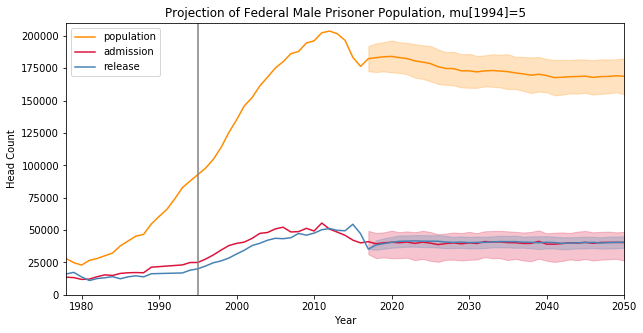

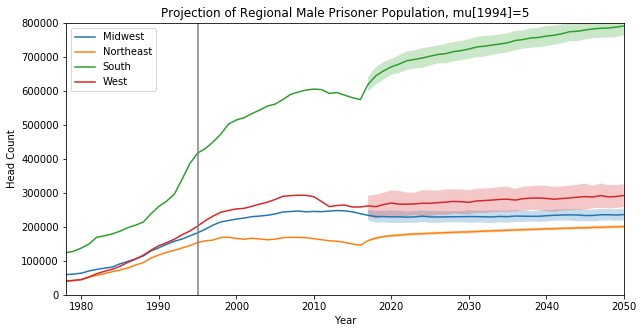

<Figure size 720x360 with 0 Axes>

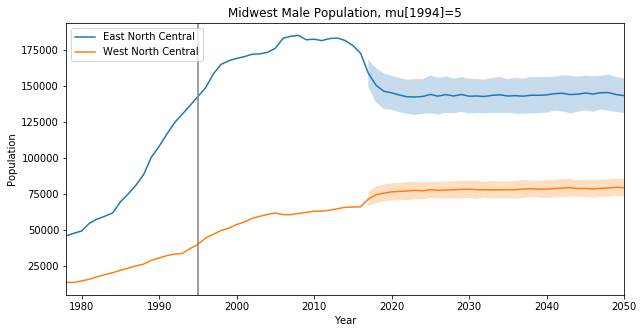

<Figure size 720x360 with 0 Axes>

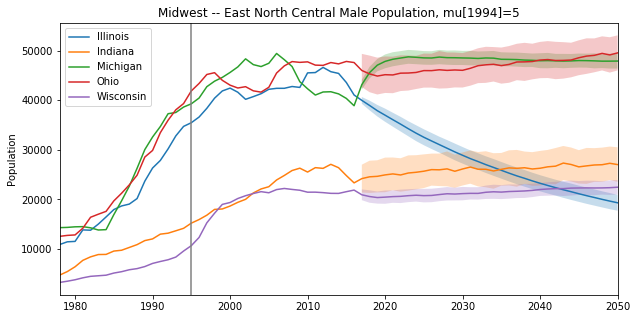

<Figure size 720x360 with 0 Axes>

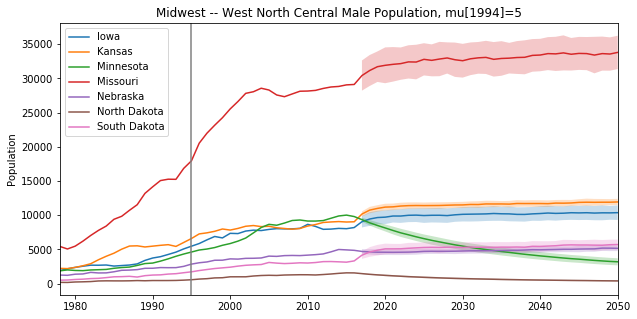

<Figure size 720x360 with 0 Axes>

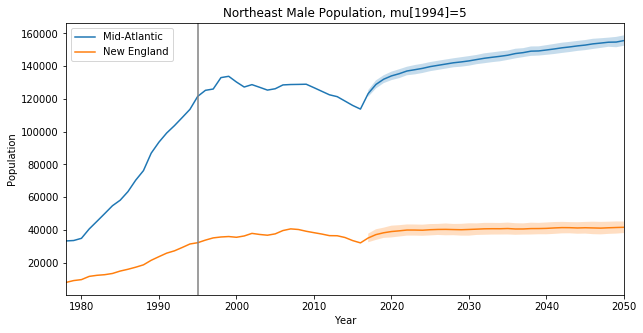

<Figure size 720x360 with 0 Axes>

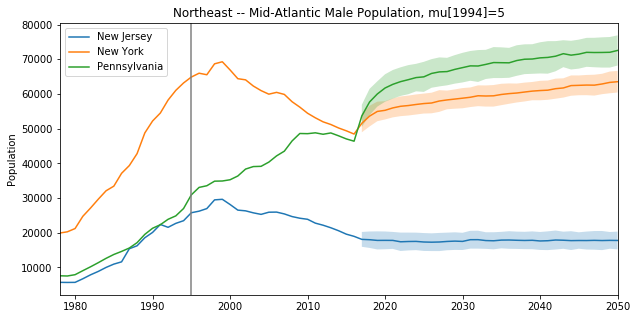

<Figure size 720x360 with 0 Axes>

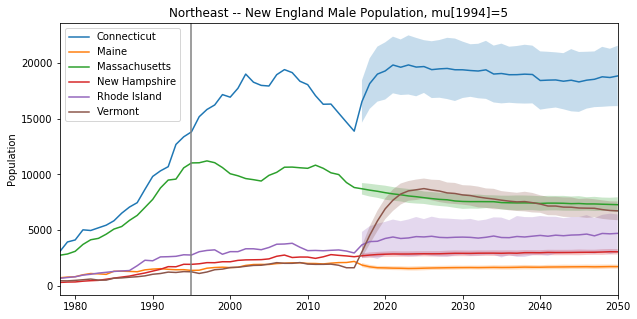

<Figure size 720x360 with 0 Axes>

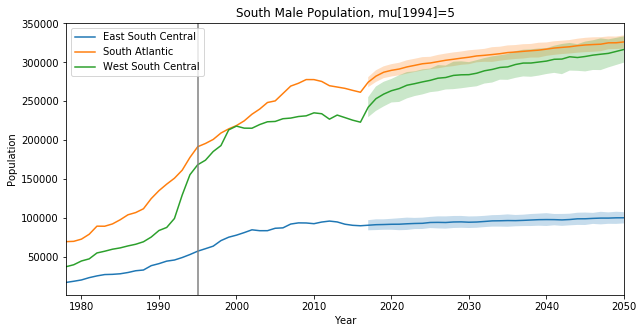

<Figure size 720x360 with 0 Axes>

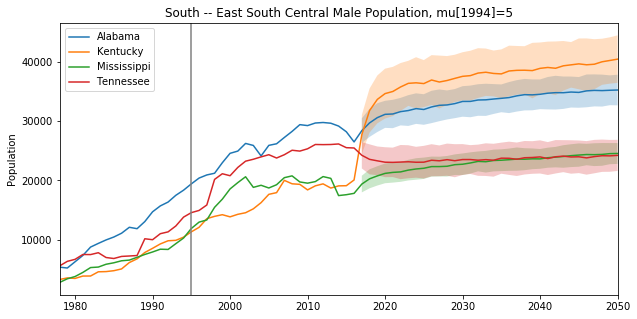

<Figure size 720x360 with 0 Axes>

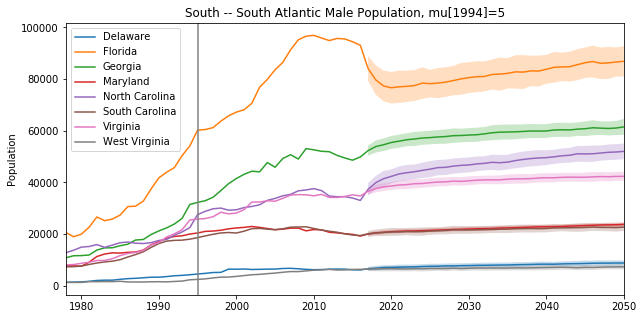

<Figure size 720x360 with 0 Axes>

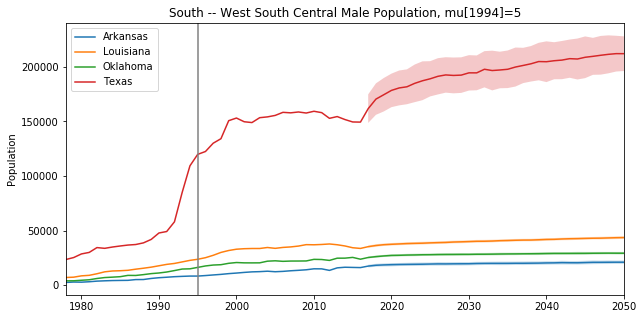

<Figure size 720x360 with 0 Axes>

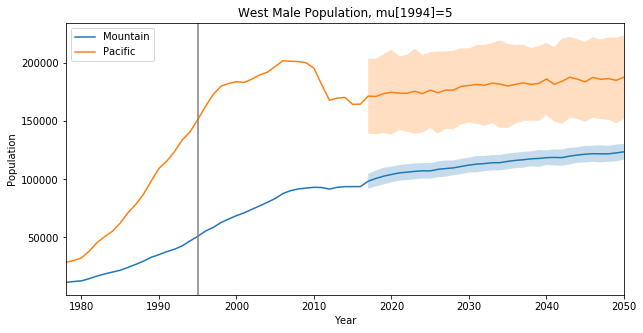

<Figure size 720x360 with 0 Axes>

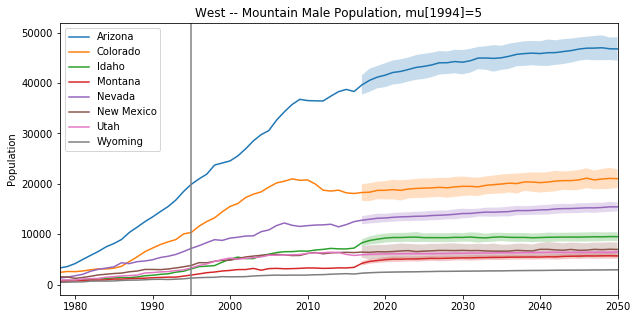

<Figure size 720x360 with 0 Axes>

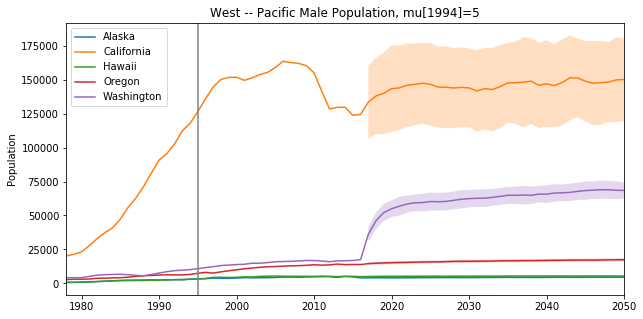

In [51]:
plotFederalProjection_GenderPopulation(malePrisonerPopulation.loc["Federal"], maleFuturePopulationMean_5.loc["Federal"],maleFuturePopulationSD_5.loc["Federal"],maleAdmission.loc["Federal"], maleFutureAdmissionMean_5.loc["Federal"],maleFutureAdmissionSD_5.loc["Federal"], maleRelease.loc["Federal"], maleFutureReleaseMean_5.loc["Federal"],maleFutureReleaseSD_5.loc["Federal"], "Male", 5, 210000)
plotRegionalProjection_GenderPopulation(malePrisonerPopulationRegionSum, maleFuturePopulationRegionSumMean_5,maleFuturePopulationRegionSumSD_5, "Male", 5, 800000)
plotDivisionalPopulationProjection_GenderPopulation(malePrisonerPopulation,maleFuturePopulationMean_5,maleFuturePopulationSD_5, malePrisonerPopulationDivisionSum,maleFuturePopulationDivisionSumMean_5,maleFuturePopulationDivisionSumSD_5, "Male",5)

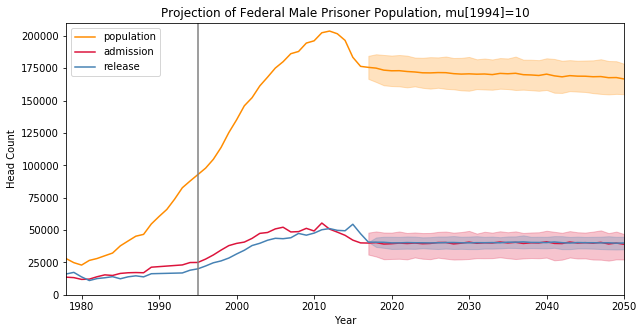

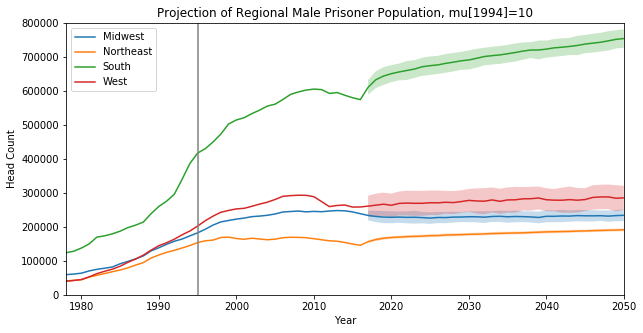

<Figure size 720x360 with 0 Axes>

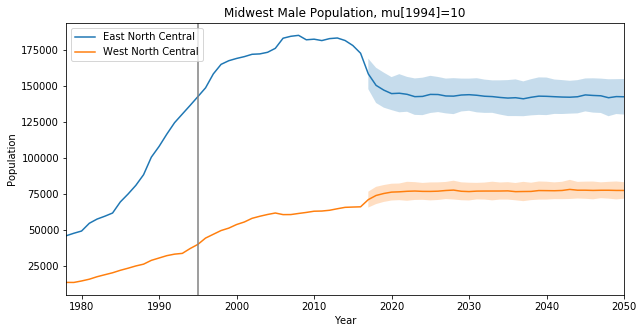

<Figure size 720x360 with 0 Axes>

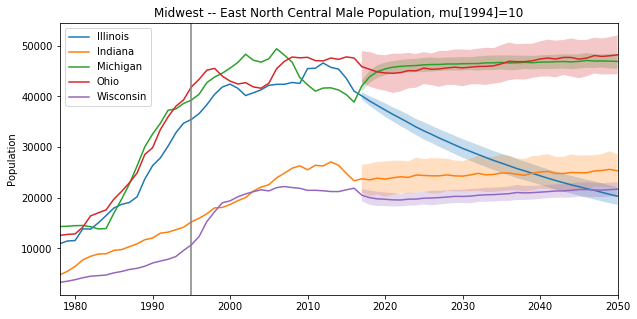

<Figure size 720x360 with 0 Axes>

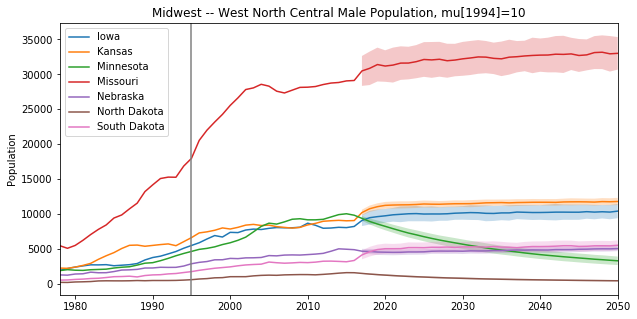

<Figure size 720x360 with 0 Axes>

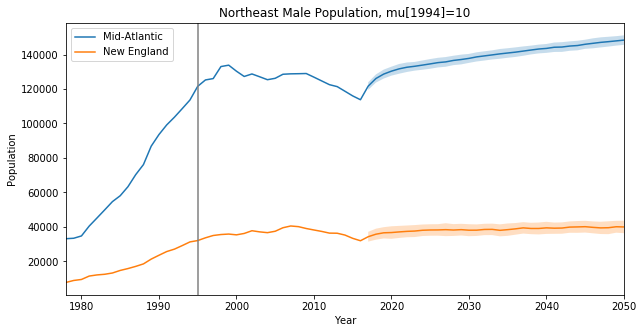

<Figure size 720x360 with 0 Axes>

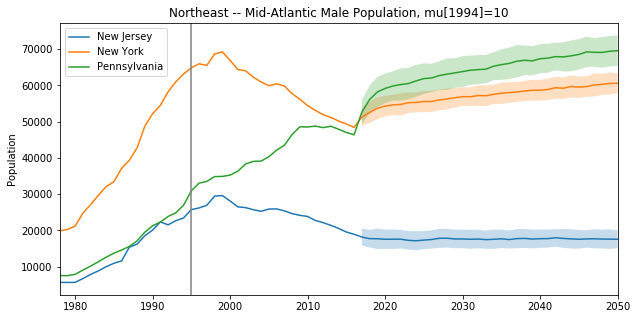

<Figure size 720x360 with 0 Axes>

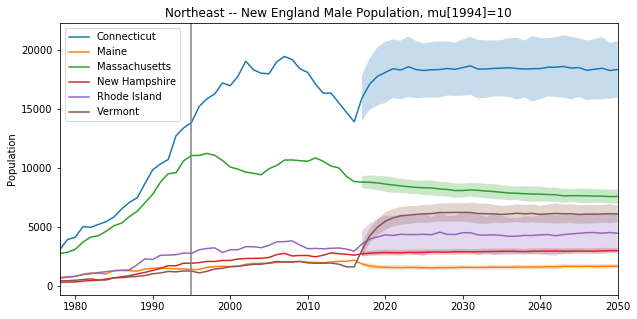

<Figure size 720x360 with 0 Axes>

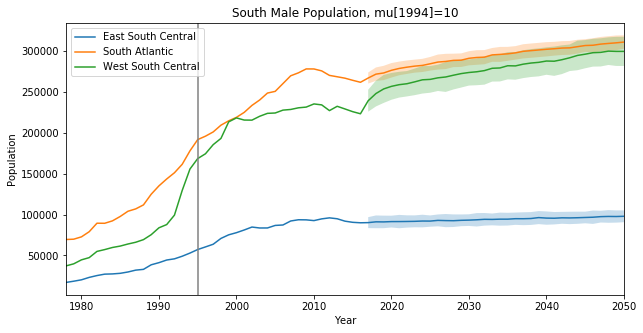

<Figure size 720x360 with 0 Axes>

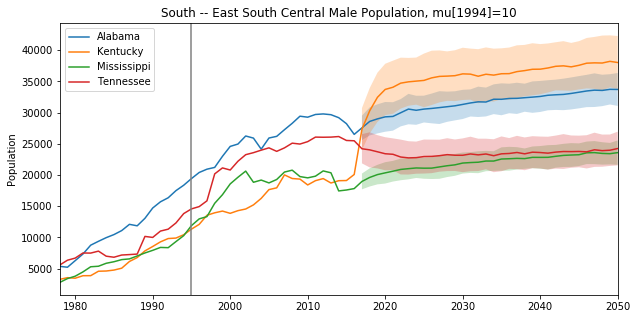

<Figure size 720x360 with 0 Axes>

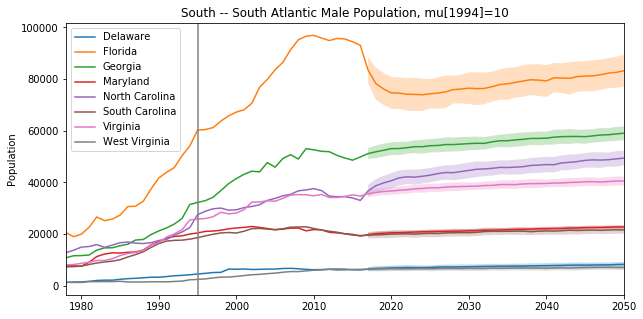

<Figure size 720x360 with 0 Axes>

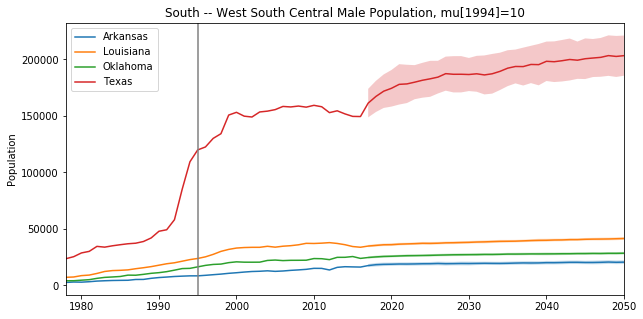

<Figure size 720x360 with 0 Axes>

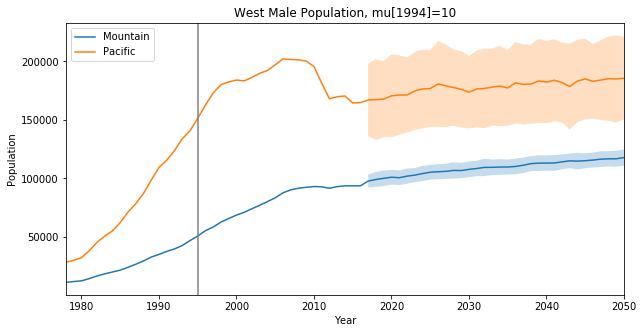

<Figure size 720x360 with 0 Axes>

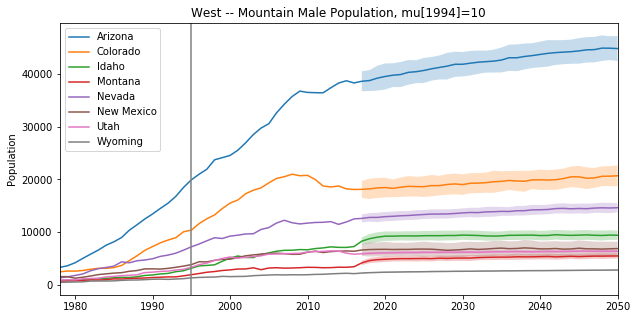

<Figure size 720x360 with 0 Axes>

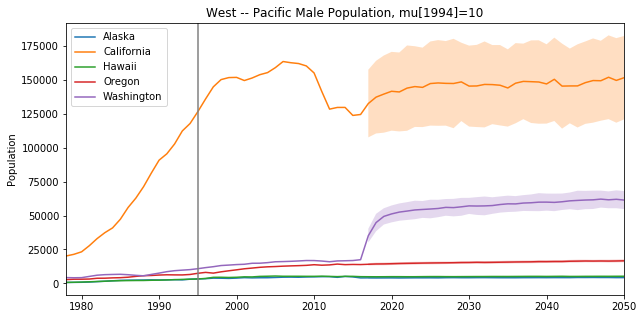

In [52]:
plotFederalProjection_GenderPopulation(malePrisonerPopulation.loc["Federal"], maleFuturePopulationMean_10.loc["Federal"],maleFuturePopulationSD_10.loc["Federal"],maleAdmission.loc["Federal"], maleFutureAdmissionMean_10.loc["Federal"],maleFutureAdmissionSD_10.loc["Federal"], maleRelease.loc["Federal"], maleFutureReleaseMean_10.loc["Federal"],maleFutureReleaseSD_10.loc["Federal"], "Male", 10, 210000)
plotRegionalProjection_GenderPopulation(malePrisonerPopulationRegionSum, maleFuturePopulationRegionSumMean_10,maleFuturePopulationRegionSumSD_10, "Male", 10, 800000)
plotDivisionalPopulationProjection_GenderPopulation(malePrisonerPopulation,maleFuturePopulationMean_10,maleFuturePopulationSD_10, malePrisonerPopulationDivisionSum,maleFuturePopulationDivisionSumMean_10,maleFuturePopulationDivisionSumSD_10, "Male",10)

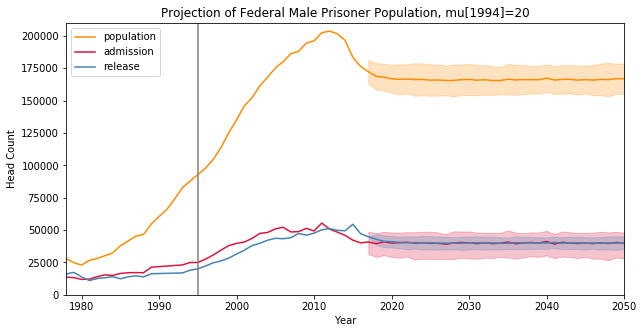

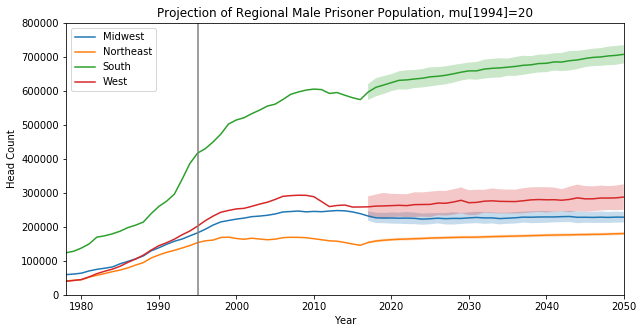

<Figure size 720x360 with 0 Axes>

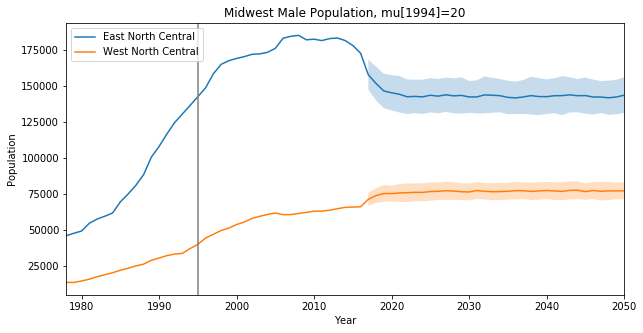

<Figure size 720x360 with 0 Axes>

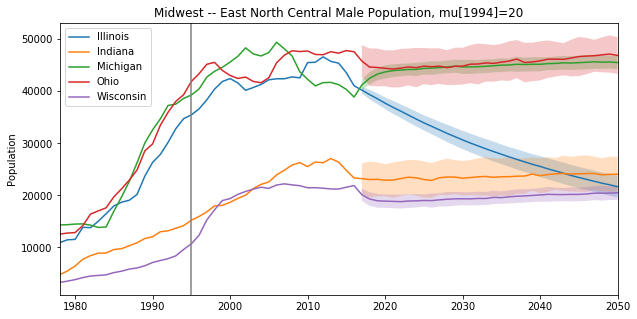

<Figure size 720x360 with 0 Axes>

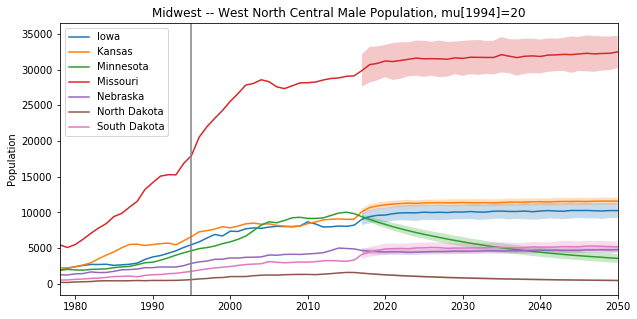

<Figure size 720x360 with 0 Axes>

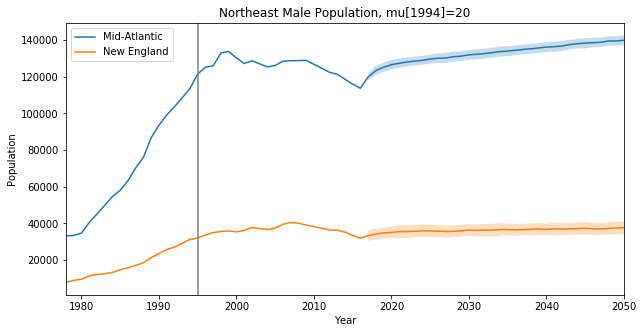

<Figure size 720x360 with 0 Axes>

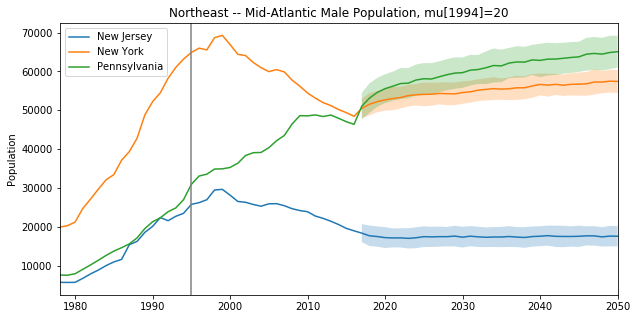

<Figure size 720x360 with 0 Axes>

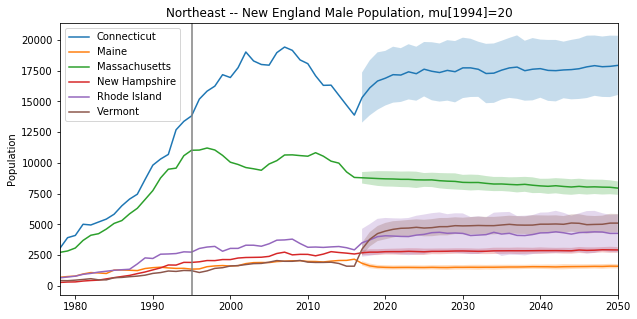

<Figure size 720x360 with 0 Axes>

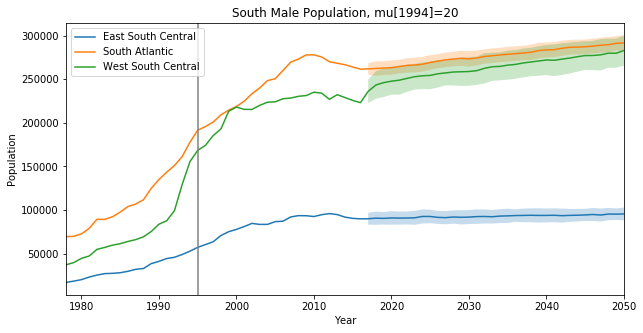

<Figure size 720x360 with 0 Axes>

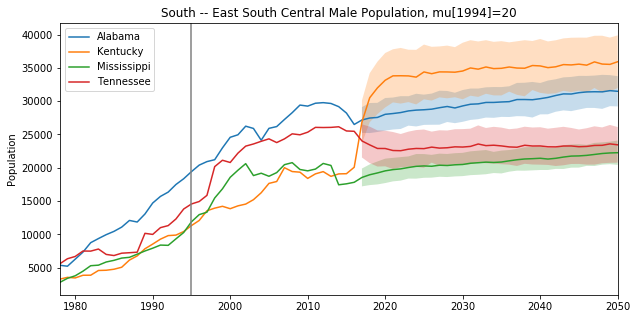

<Figure size 720x360 with 0 Axes>

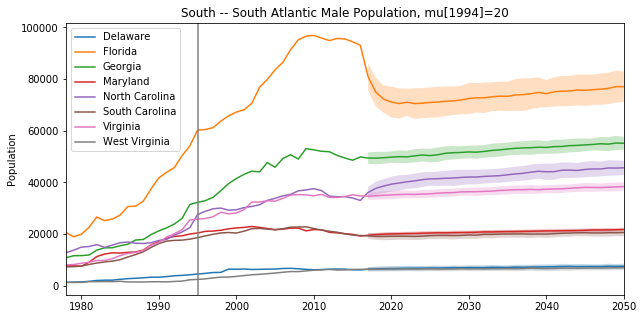

<Figure size 720x360 with 0 Axes>

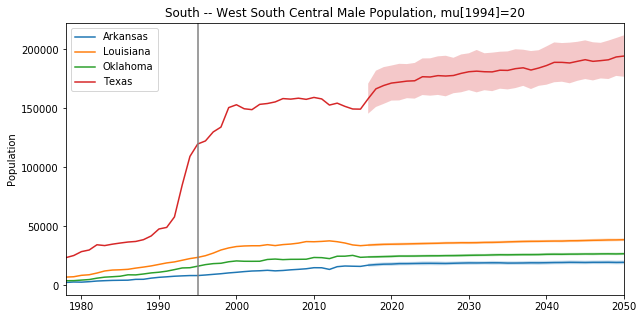

<Figure size 720x360 with 0 Axes>

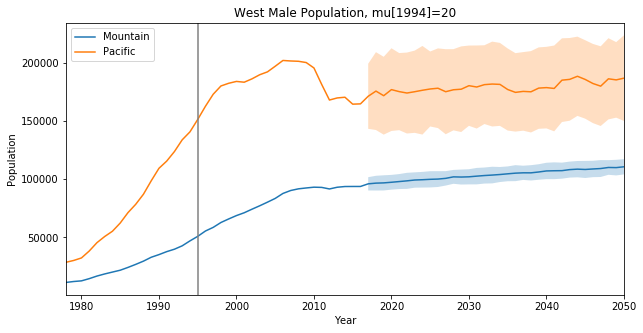

<Figure size 720x360 with 0 Axes>

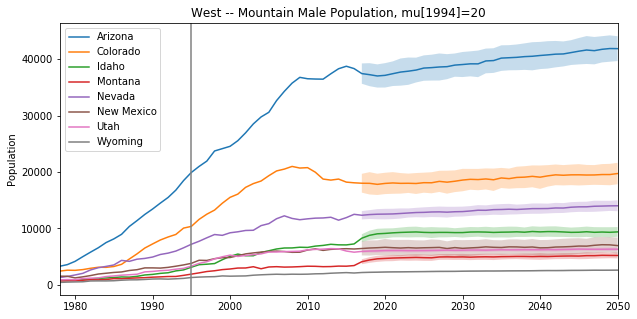

<Figure size 720x360 with 0 Axes>

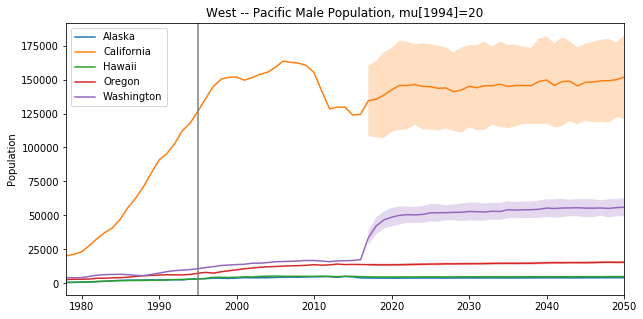

In [53]:
plotFederalProjection_GenderPopulation(malePrisonerPopulation.loc["Federal"], maleFuturePopulationMean_20.loc["Federal"],maleFuturePopulationSD_20.loc["Federal"],maleAdmission.loc["Federal"], maleFutureAdmissionMean_20.loc["Federal"],maleFutureAdmissionSD_20.loc["Federal"], maleRelease.loc["Federal"], maleFutureReleaseMean_20.loc["Federal"],maleFutureReleaseSD_20.loc["Federal"], "Male", 20, 210000)
plotRegionalProjection_GenderPopulation(malePrisonerPopulationRegionSum, maleFuturePopulationRegionSumMean_20,maleFuturePopulationRegionSumSD_20, "Male", 20, 800000)
plotDivisionalPopulationProjection_GenderPopulation(malePrisonerPopulation,maleFuturePopulationMean_20,maleFuturePopulationSD_20, malePrisonerPopulationDivisionSum,maleFuturePopulationDivisionSumMean_20,maleFuturePopulationDivisionSumSD_20, "Male",20)

In [54]:
femalePrisonerPopulationRegionSum

Year         1978    1979    1980    1981    1982    1983    1984    1985  \
Region                                                                      
Federal    1828.0  1536.0  1399.0  1559.0  1627.0  1754.0  1996.0  2404.0   
Midwest    2349.0  2576.0  2590.0  2980.0  3440.0  3601.0  3837.0  4317.0   
Northeast  1241.0  1313.0  1463.0  1881.0  1972.0  2182.0  2499.0  2713.0   
South      5181.0  5348.0  5689.0  6555.0  7670.0  7824.0  8353.0  8759.0   
West       2067.0  2148.0  2209.0  2446.0  2897.0  3432.0  3903.0  4727.0   

Year         1986     1987  ...     2007     2008     2009     2010     2011  \
Region                      ...                                                
Federal    2833.0   3027.0  ...  13338.0  13273.0  13625.0  13549.0  13900.0   
Midwest    4800.0   5344.0  ...  17929.0  17783.0  17455.0  18055.0  17956.0   
Northeast  3161.0   3755.0  ...   9654.0   9601.0   9287.0   8812.0   8853.0   
South      9955.0  10178.0  ...  48352.0  49019.0  48972.0  49218.0  49284.0   
West       5533.0   6469.0  ...  25038.0  24936.0  24146.0  23233.0  21414.0   

Year          2012     2013     2014     2015     2016  
Region                                                  
Federal    14049.0  14169.0  13999.0  12953.0  12697.0  
Midwest    18271.0  19124.0  19913.0  20064.0  20078.0  
Northeast   8718.0   8829.0   8698.0   8595.0   8392.0  
South      48372.0  49164.0  49941.0  50202.0  50321.0  
West       19362.0  20072.0  20477.0  19677.0  19934.0  

[5 rows x 39 columns]

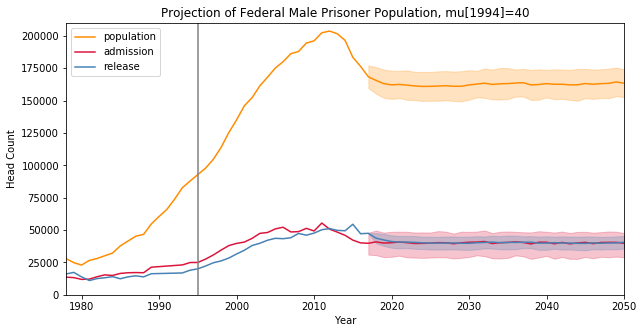

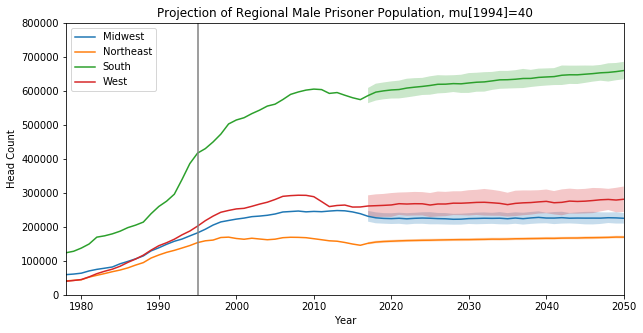

<Figure size 720x360 with 0 Axes>

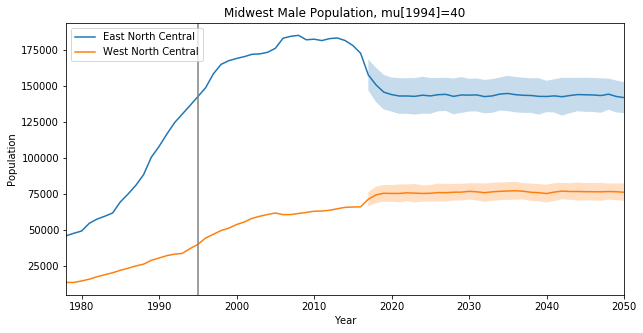

<Figure size 720x360 with 0 Axes>

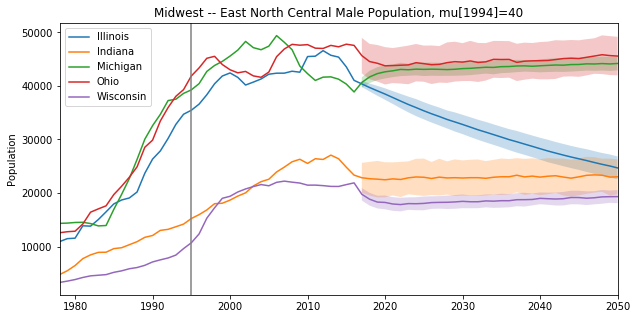

<Figure size 720x360 with 0 Axes>

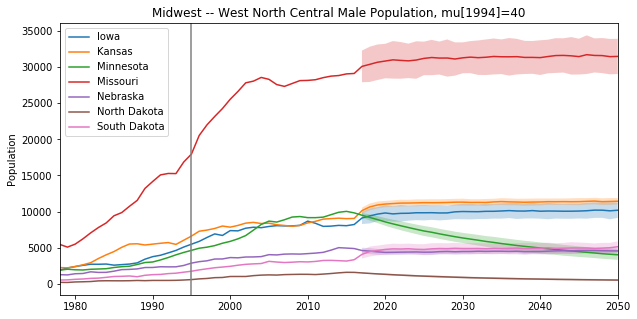

<Figure size 720x360 with 0 Axes>

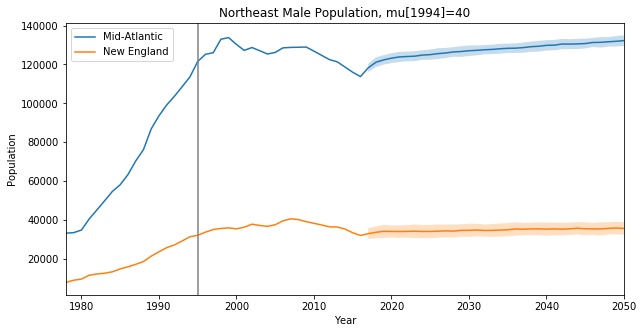

<Figure size 720x360 with 0 Axes>

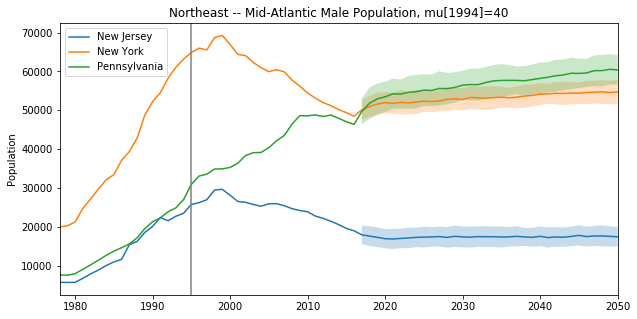

<Figure size 720x360 with 0 Axes>

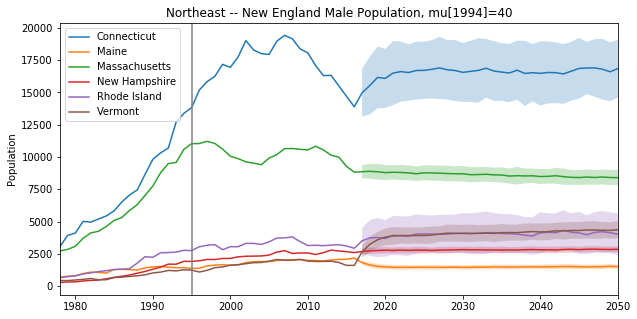

<Figure size 720x360 with 0 Axes>

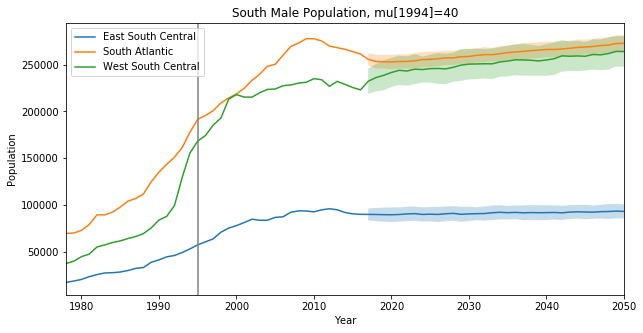

<Figure size 720x360 with 0 Axes>

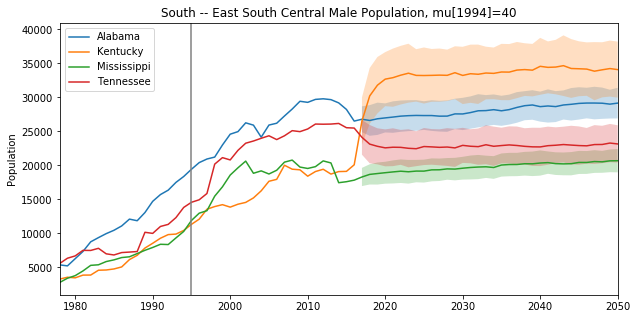

<Figure size 720x360 with 0 Axes>

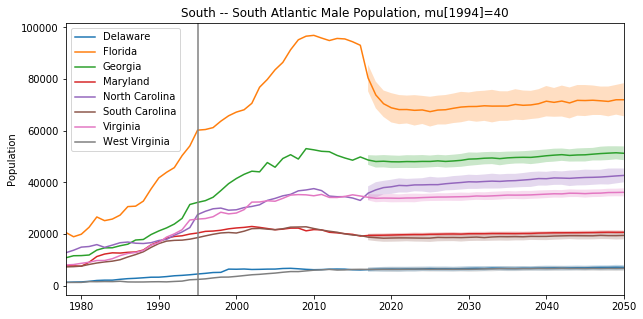

<Figure size 720x360 with 0 Axes>

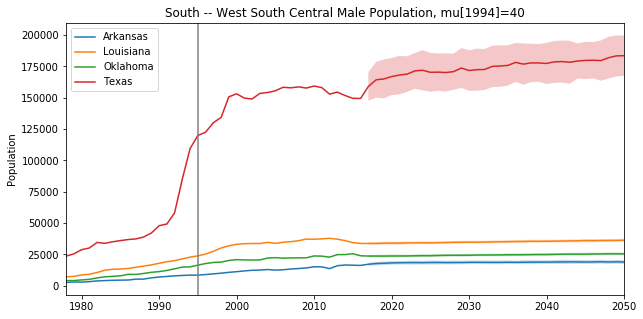

<Figure size 720x360 with 0 Axes>

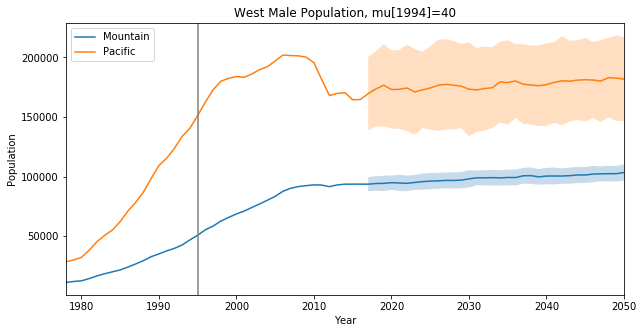

<Figure size 720x360 with 0 Axes>

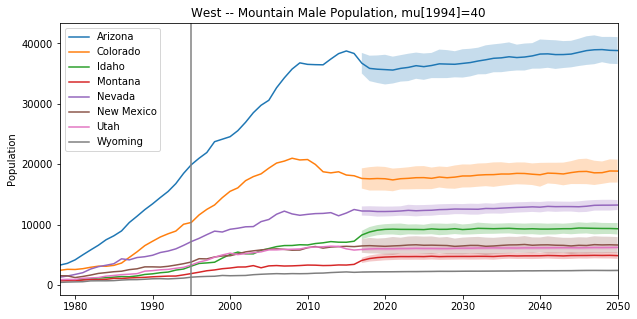

<Figure size 720x360 with 0 Axes>

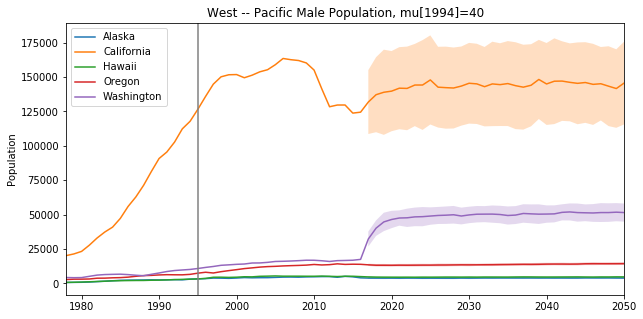

In [55]:
plotFederalProjection_GenderPopulation(malePrisonerPopulation.loc["Federal"], maleFuturePopulationMean_40.loc["Federal"],maleFuturePopulationSD_40.loc["Federal"],maleAdmission.loc["Federal"], maleFutureAdmissionMean_40.loc["Federal"],maleFutureAdmissionSD_40.loc["Federal"], maleRelease.loc["Federal"], maleFutureReleaseMean_40.loc["Federal"],maleFutureReleaseSD_40.loc["Federal"], "Male", 40, 210000)
plotRegionalProjection_GenderPopulation(malePrisonerPopulationRegionSum, maleFuturePopulationRegionSumMean_40,maleFuturePopulationRegionSumSD_40, "Male", 40, 800000)
plotDivisionalPopulationProjection_GenderPopulation(malePrisonerPopulation,maleFuturePopulationMean_40,maleFuturePopulationSD_40, malePrisonerPopulationDivisionSum,maleFuturePopulationDivisionSumMean_40,maleFuturePopulationDivisionSumSD_40, "Male",40)

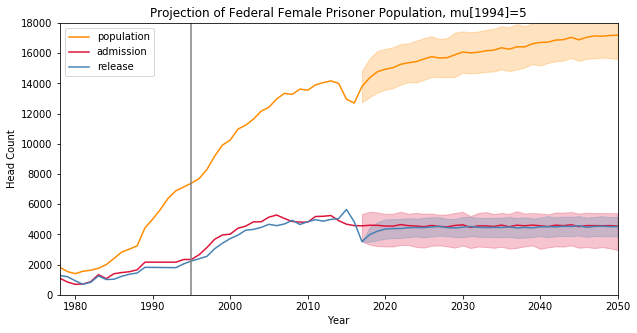

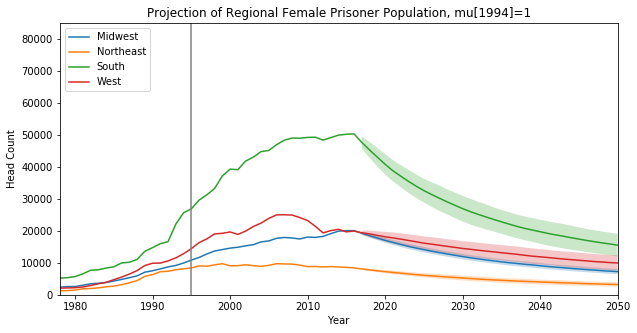

<Figure size 720x360 with 0 Axes>

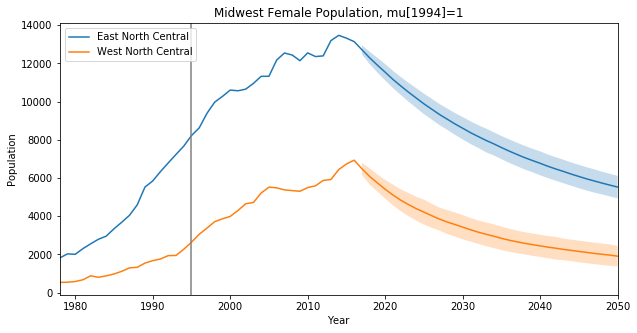

<Figure size 720x360 with 0 Axes>

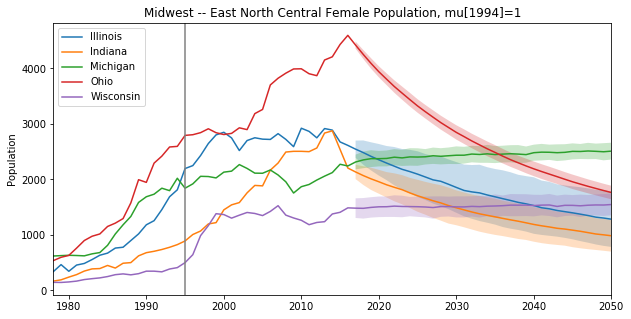

<Figure size 720x360 with 0 Axes>

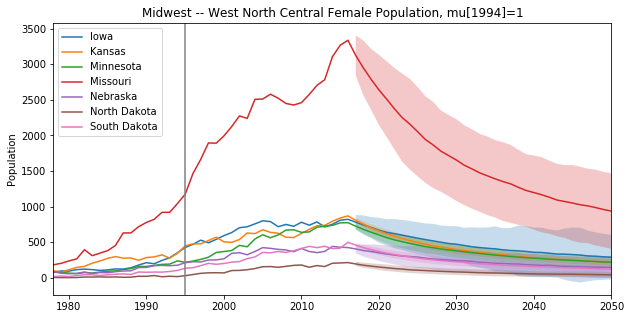

<Figure size 720x360 with 0 Axes>

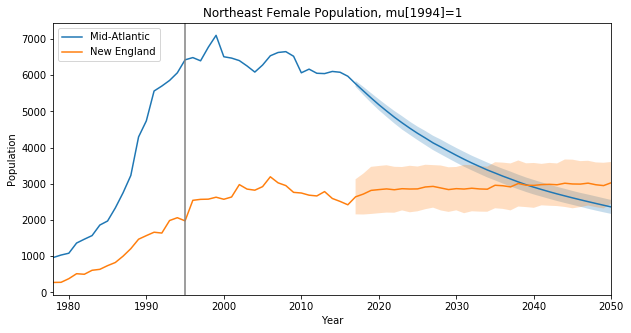

<Figure size 720x360 with 0 Axes>

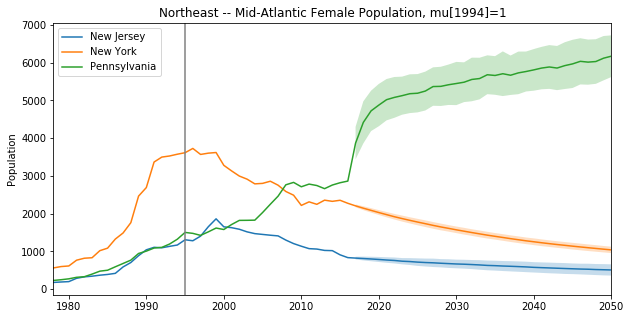

<Figure size 720x360 with 0 Axes>

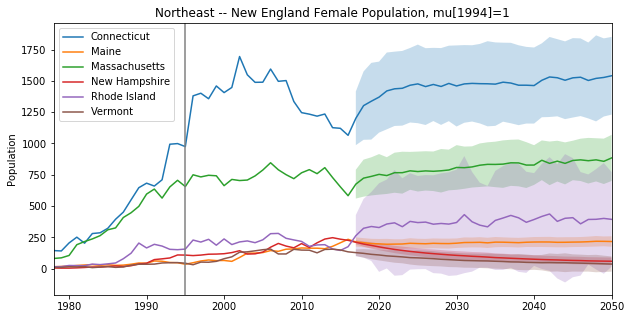

<Figure size 720x360 with 0 Axes>

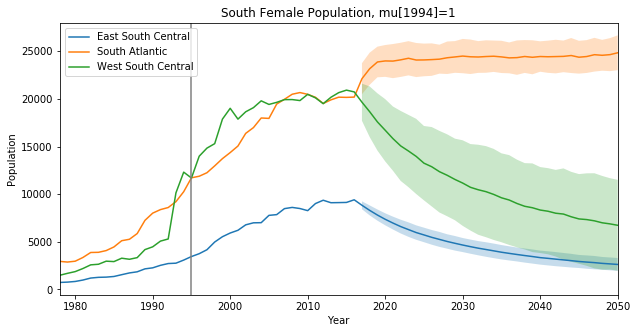

<Figure size 720x360 with 0 Axes>

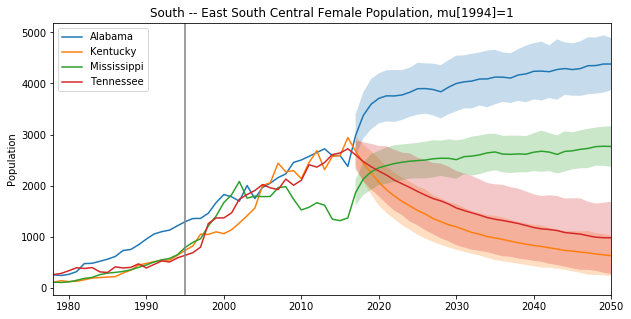

<Figure size 720x360 with 0 Axes>

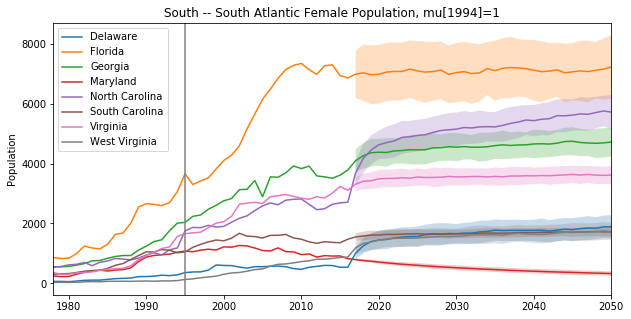

<Figure size 720x360 with 0 Axes>

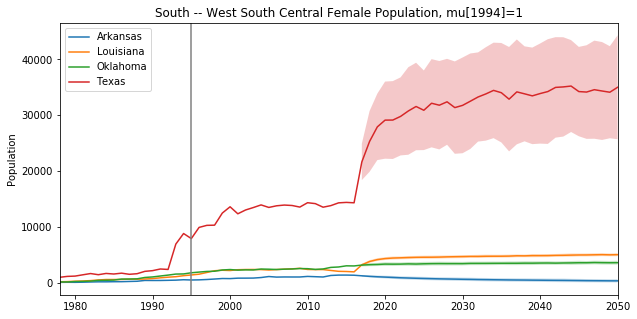

<Figure size 720x360 with 0 Axes>

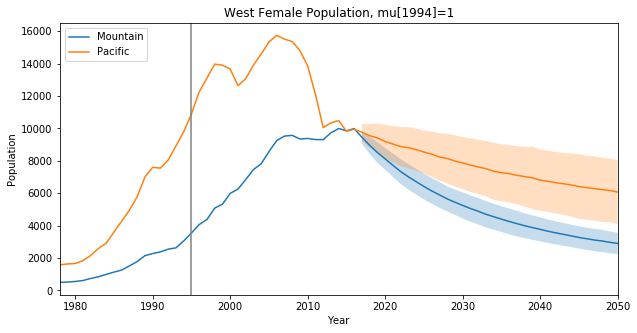

<Figure size 720x360 with 0 Axes>

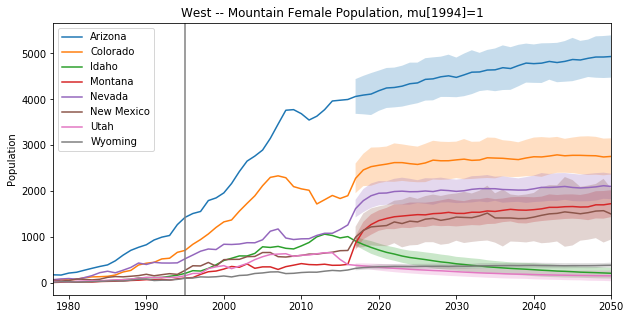

<Figure size 720x360 with 0 Axes>

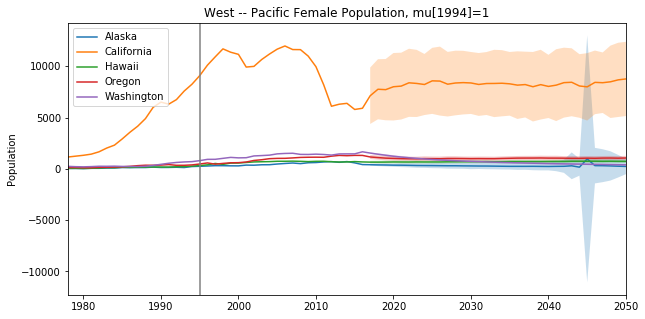

In [56]:
plotFederalProjection_GenderPopulation(femalePrisonerPopulation.loc["Federal"], femaleFuturePopulationMean_5.loc["Federal"],femaleFuturePopulationSD_5.loc["Federal"],femaleAdmission.loc["Federal"], femaleFutureAdmissionMean_5.loc["Federal"],femaleFutureAdmissionSD_5.loc["Federal"], femaleRelease.loc["Federal"], femaleFutureReleaseMean_5.loc["Federal"],femaleFutureReleaseSD_5.loc["Federal"], "Female", 5, 18000)
plotRegionalProjection_GenderPopulation(femalePrisonerPopulationRegionSum, femaleFuturePopulationRegionSumMean_5,femaleFuturePopulationRegionSumSD_5, "Female", 1, 85000)
plotDivisionalPopulationProjection_GenderPopulation(femalePrisonerPopulation,femaleFuturePopulationMean_5,femaleFuturePopulationSD_5, femalePrisonerPopulationDivisionSum,femaleFuturePopulationDivisionSumMean_5,femaleFuturePopulationDivisionSumSD_5, "Female",1)

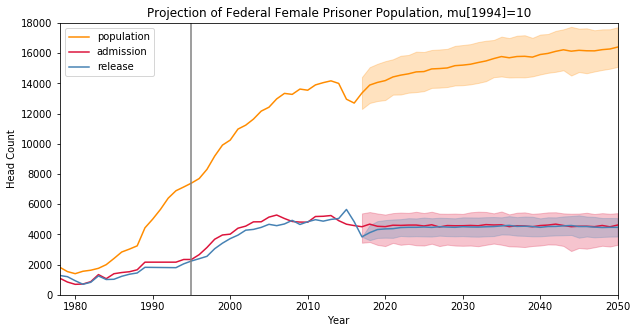

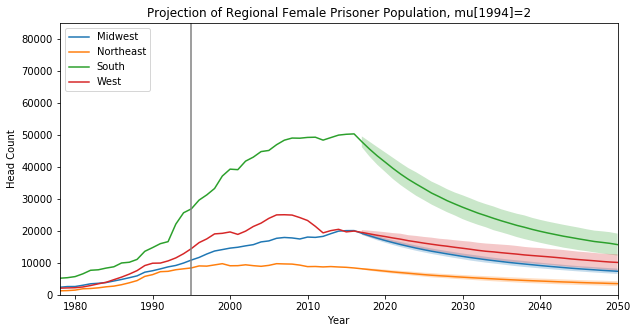

<Figure size 720x360 with 0 Axes>

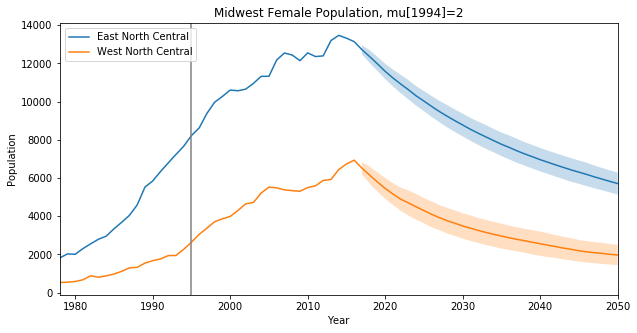

<Figure size 720x360 with 0 Axes>

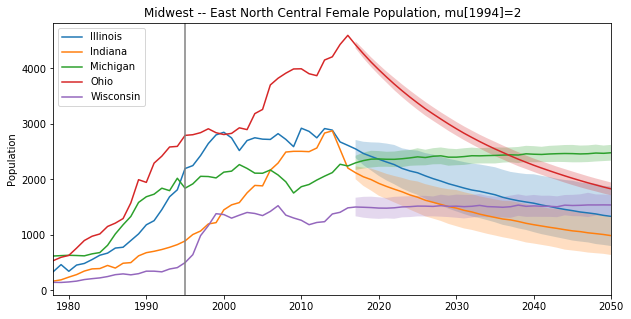

<Figure size 720x360 with 0 Axes>

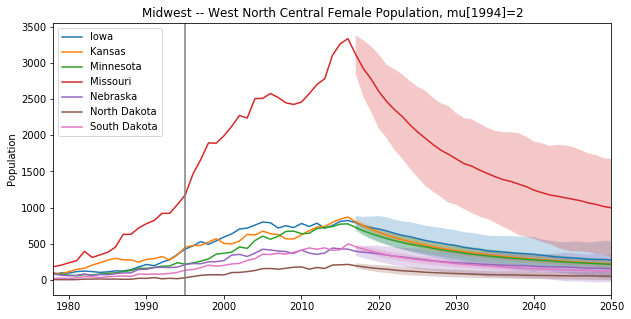

<Figure size 720x360 with 0 Axes>

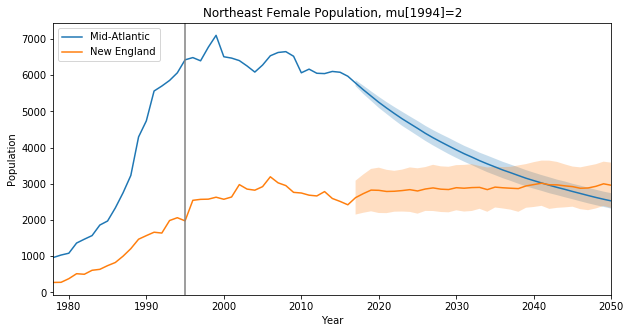

<Figure size 720x360 with 0 Axes>

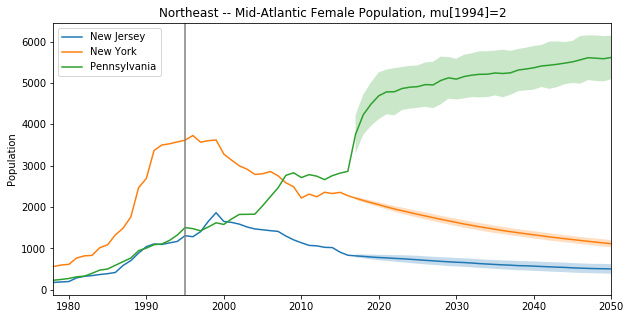

<Figure size 720x360 with 0 Axes>

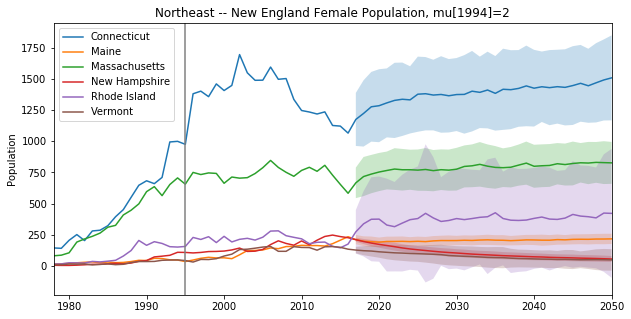

<Figure size 720x360 with 0 Axes>

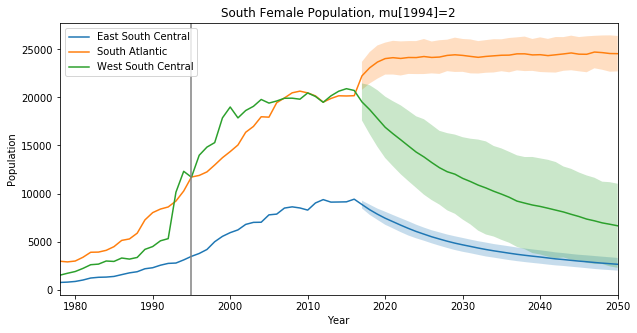

<Figure size 720x360 with 0 Axes>

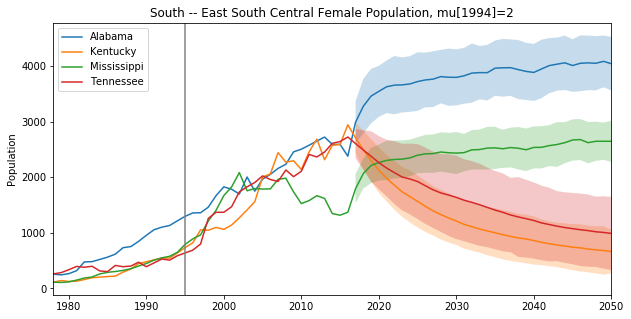

<Figure size 720x360 with 0 Axes>

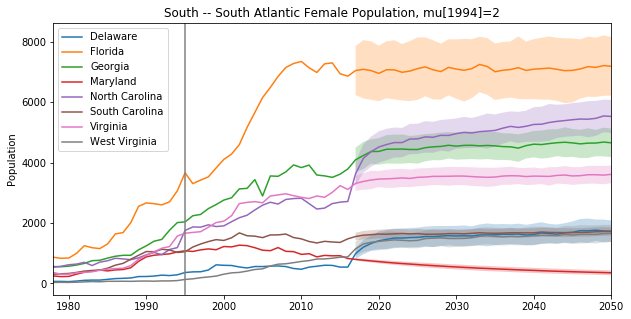

<Figure size 720x360 with 0 Axes>

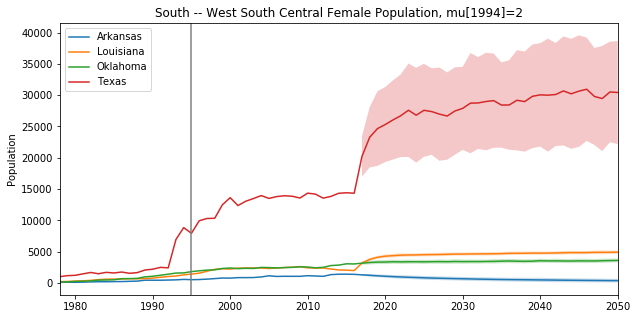

<Figure size 720x360 with 0 Axes>

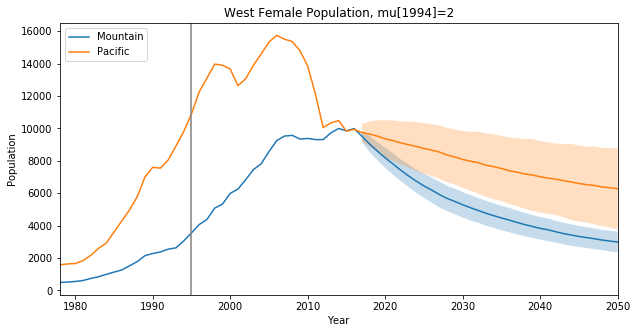

<Figure size 720x360 with 0 Axes>

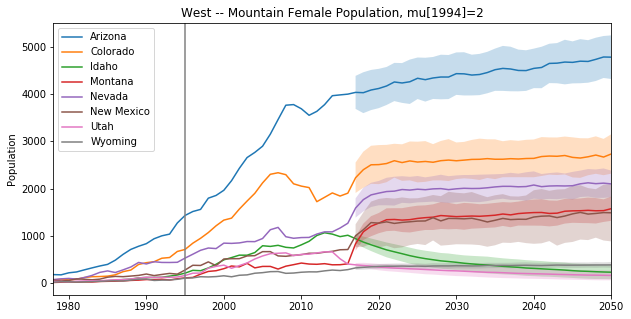

<Figure size 720x360 with 0 Axes>

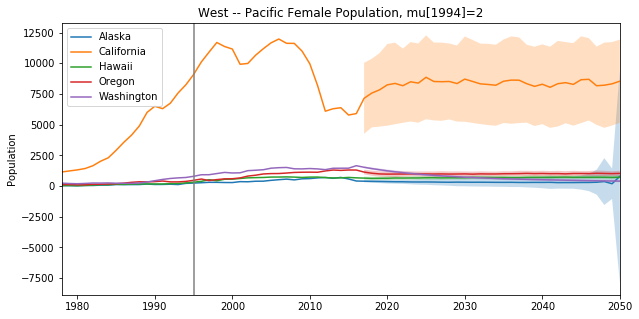

In [57]:
plotFederalProjection_GenderPopulation(femalePrisonerPopulation.loc["Federal"], femaleFuturePopulationMean_10.loc["Federal"],femaleFuturePopulationSD_10.loc["Federal"],femaleAdmission.loc["Federal"], femaleFutureAdmissionMean_10.loc["Federal"],femaleFutureAdmissionSD_10.loc["Federal"], femaleRelease.loc["Federal"], femaleFutureReleaseMean_10.loc["Federal"],femaleFutureReleaseSD_10.loc["Federal"], "Female", 10, 18000)
plotRegionalProjection_GenderPopulation(femalePrisonerPopulationRegionSum, femaleFuturePopulationRegionSumMean_10,femaleFuturePopulationRegionSumSD_10, "Female", 2, 85000)
plotDivisionalPopulationProjection_GenderPopulation(femalePrisonerPopulation,femaleFuturePopulationMean_10,femaleFuturePopulationSD_10, femalePrisonerPopulationDivisionSum,femaleFuturePopulationDivisionSumMean_10,femaleFuturePopulationDivisionSumSD_10, "Female",2)

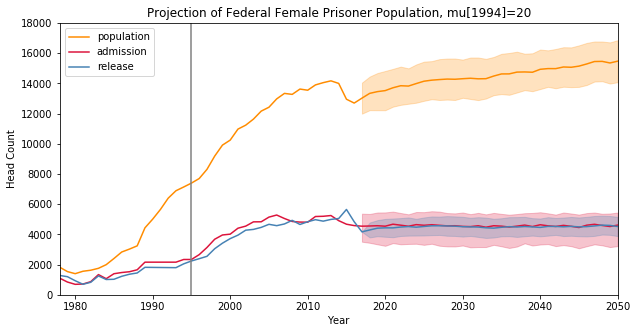

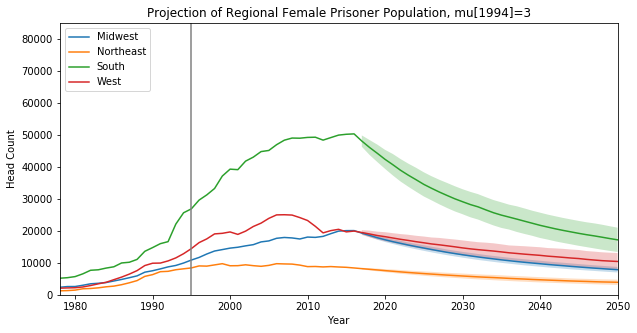

<Figure size 720x360 with 0 Axes>

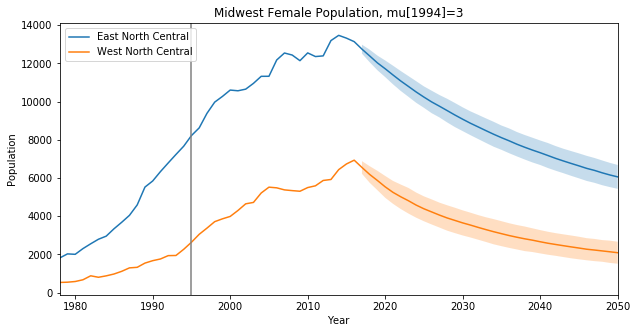

<Figure size 720x360 with 0 Axes>

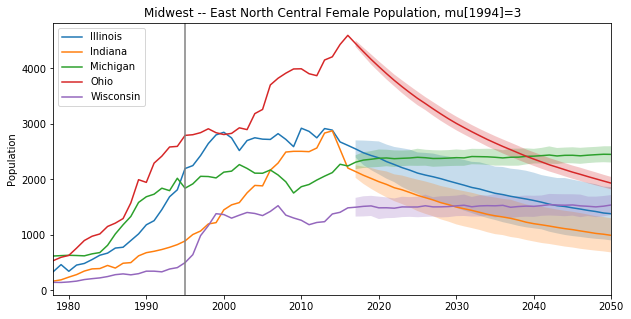

<Figure size 720x360 with 0 Axes>

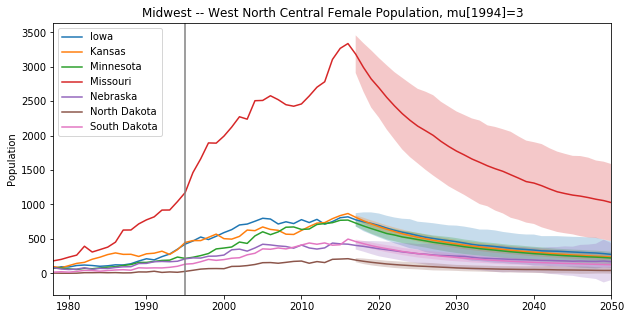

<Figure size 720x360 with 0 Axes>

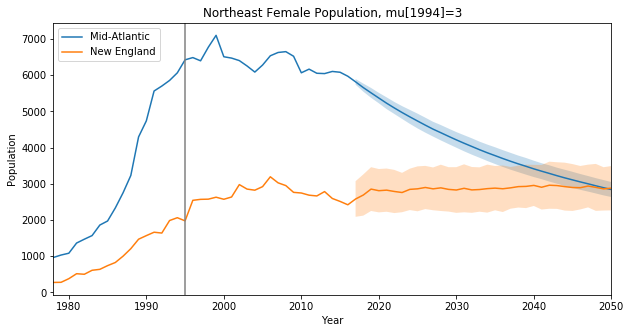

<Figure size 720x360 with 0 Axes>

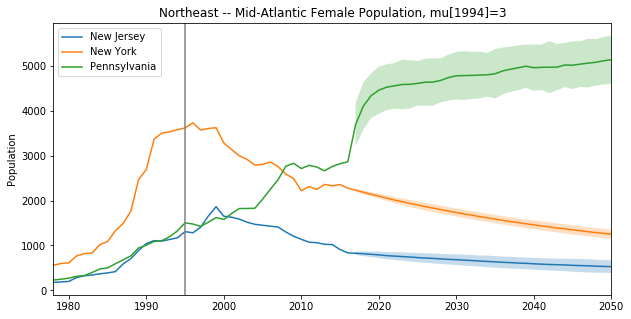

<Figure size 720x360 with 0 Axes>

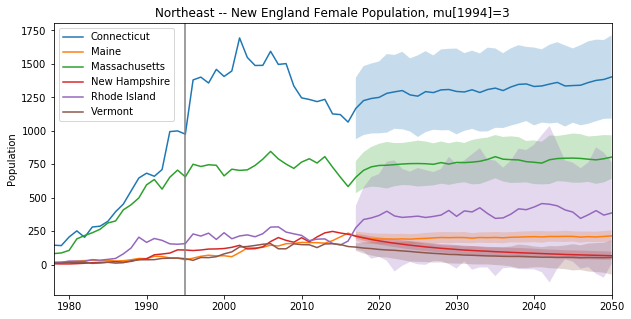

<Figure size 720x360 with 0 Axes>

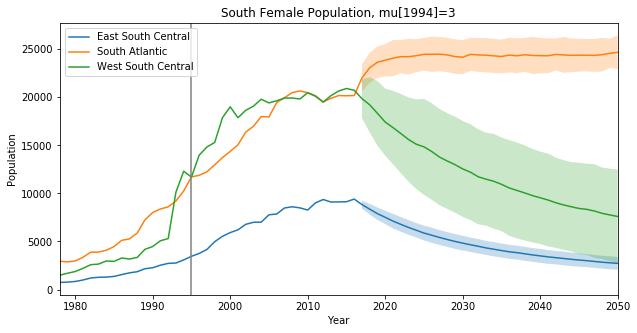

<Figure size 720x360 with 0 Axes>

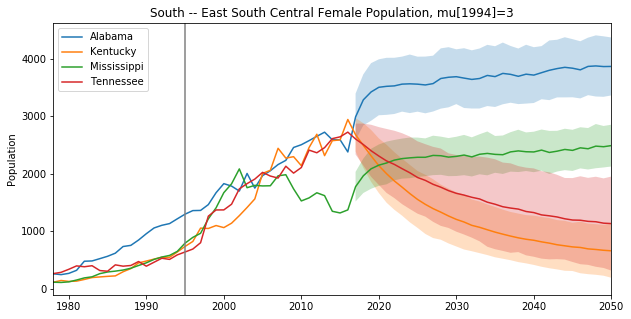

<Figure size 720x360 with 0 Axes>

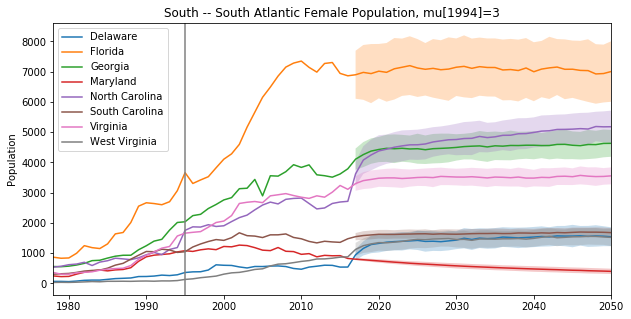

<Figure size 720x360 with 0 Axes>

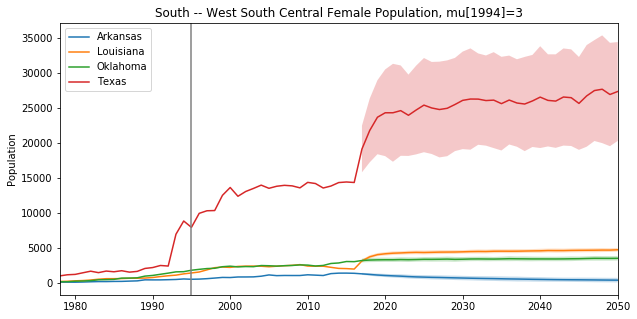

<Figure size 720x360 with 0 Axes>

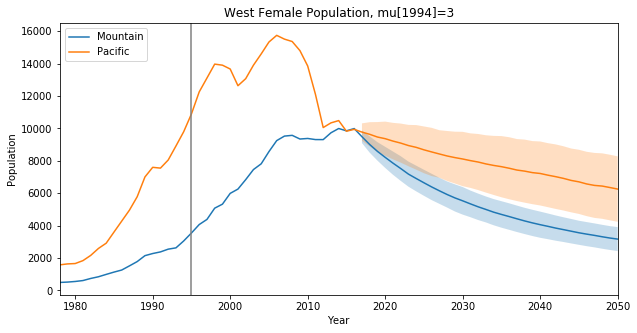

<Figure size 720x360 with 0 Axes>

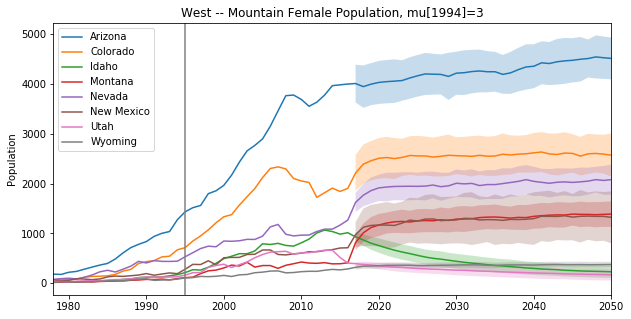

<Figure size 720x360 with 0 Axes>

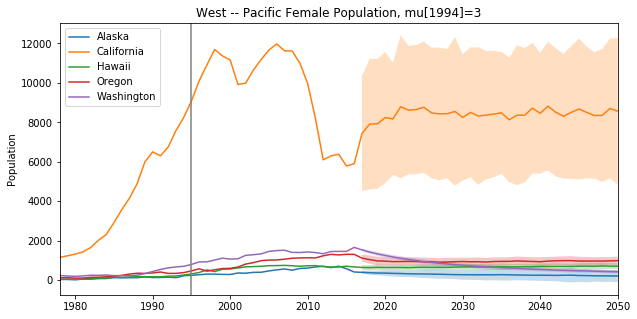

In [58]:
plotFederalProjection_GenderPopulation(femalePrisonerPopulation.loc["Federal"], femaleFuturePopulationMean_20.loc["Federal"],femaleFuturePopulationSD_20.loc["Federal"],femaleAdmission.loc["Federal"], femaleFutureAdmissionMean_20.loc["Federal"],femaleFutureAdmissionSD_20.loc["Federal"], femaleRelease.loc["Federal"], femaleFutureReleaseMean_20.loc["Federal"],femaleFutureReleaseSD_20.loc["Federal"], "Female", 20, 18000)
plotRegionalProjection_GenderPopulation(femalePrisonerPopulationRegionSum, femaleFuturePopulationRegionSumMean_20,femaleFuturePopulationRegionSumSD_20, "Female", 3, 85000)
plotDivisionalPopulationProjection_GenderPopulation(femalePrisonerPopulation,femaleFuturePopulationMean_20,femaleFuturePopulationSD_20, femalePrisonerPopulationDivisionSum,femaleFuturePopulationDivisionSumMean_20,femaleFuturePopulationDivisionSumSD_20, "Female",3)

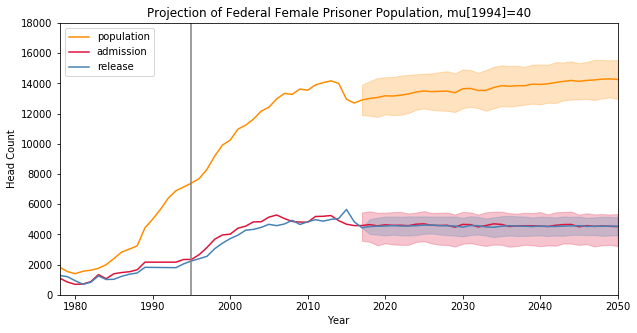

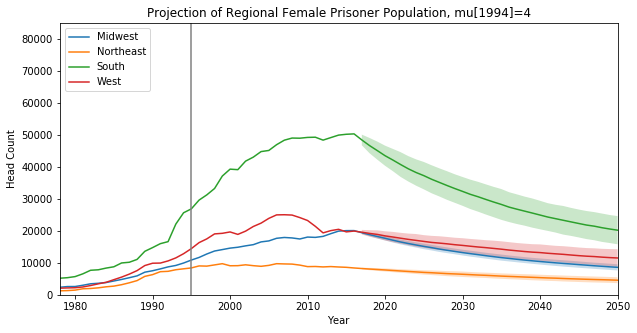

<Figure size 720x360 with 0 Axes>

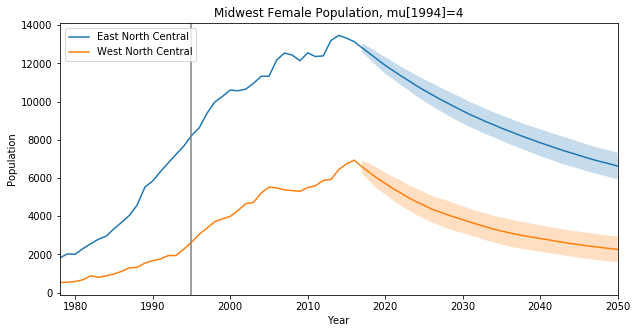

<Figure size 720x360 with 0 Axes>

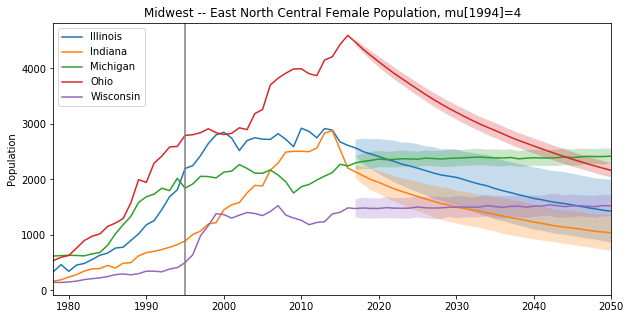

<Figure size 720x360 with 0 Axes>

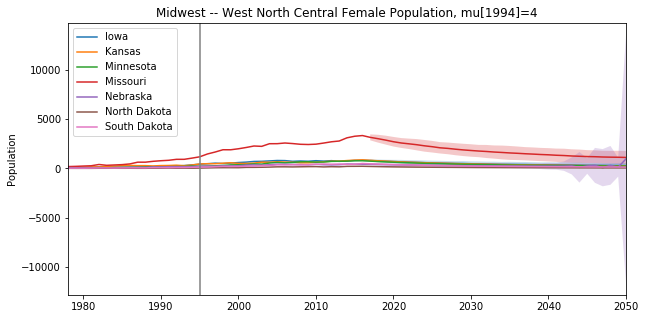

<Figure size 720x360 with 0 Axes>

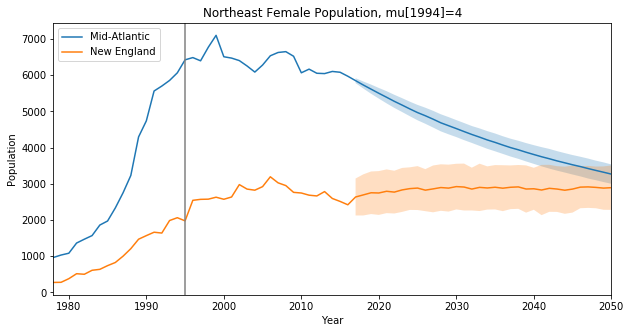

<Figure size 720x360 with 0 Axes>

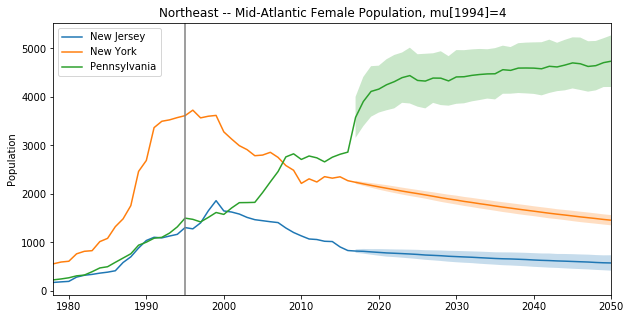

<Figure size 720x360 with 0 Axes>

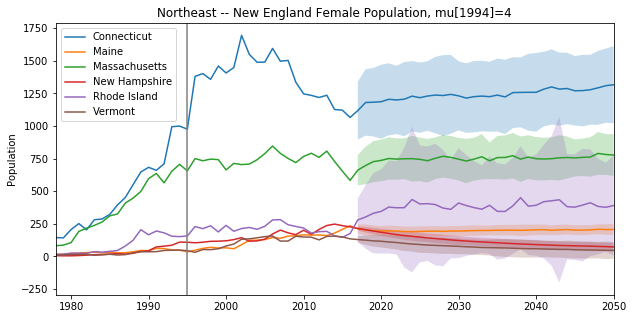

<Figure size 720x360 with 0 Axes>

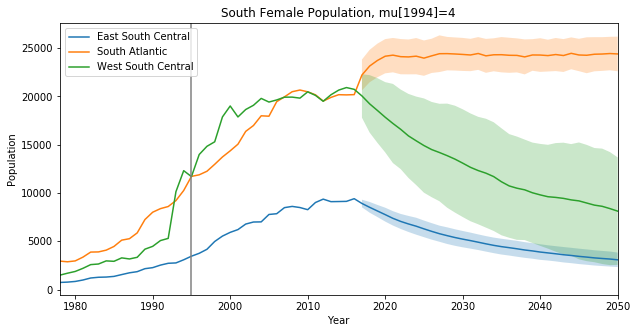

<Figure size 720x360 with 0 Axes>

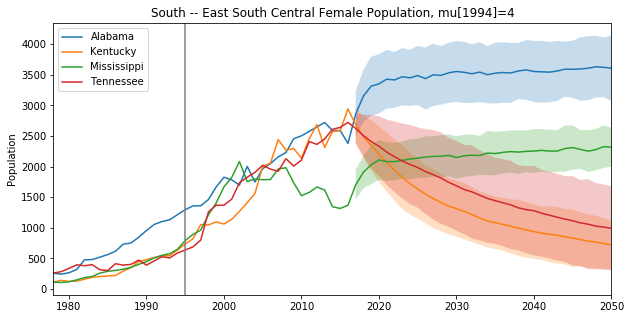

<Figure size 720x360 with 0 Axes>

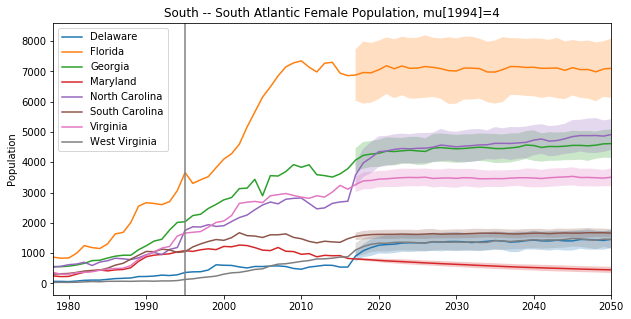

<Figure size 720x360 with 0 Axes>

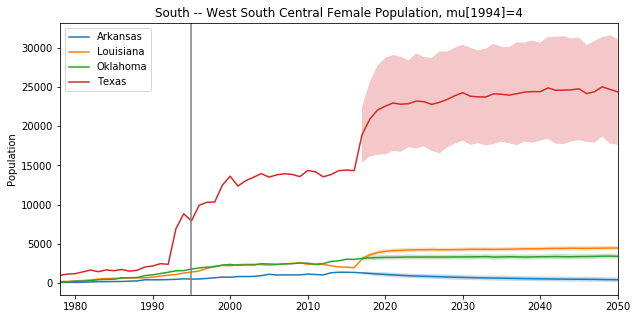

<Figure size 720x360 with 0 Axes>

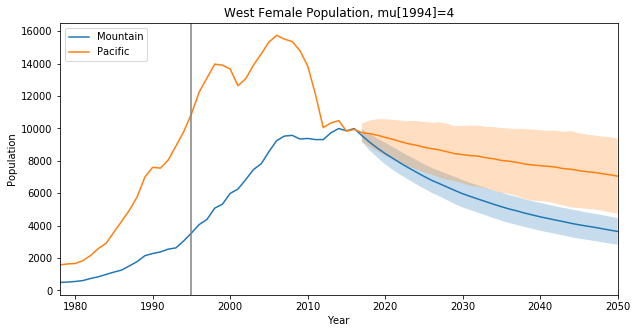

<Figure size 720x360 with 0 Axes>

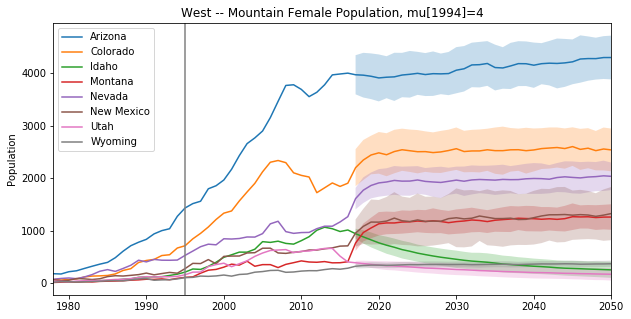

<Figure size 720x360 with 0 Axes>

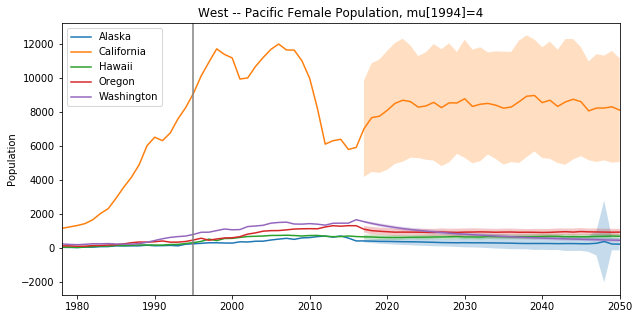

In [59]:
plotFederalProjection_GenderPopulation(femalePrisonerPopulation.loc["Federal"], femaleFuturePopulationMean_40.loc["Federal"],femaleFuturePopulationSD_40.loc["Federal"],femaleAdmission.loc["Federal"], femaleFutureAdmissionMean_40.loc["Federal"],femaleFutureAdmissionSD_40.loc["Federal"], femaleRelease.loc["Federal"], femaleFutureReleaseMean_40.loc["Federal"],femaleFutureReleaseSD_40.loc["Federal"], "Female", 40, 18000)
plotRegionalProjection_GenderPopulation(femalePrisonerPopulationRegionSum, femaleFuturePopulationRegionSumMean_40,femaleFuturePopulationRegionSumSD_40, "Female", 4, 85000)
plotDivisionalPopulationProjection_GenderPopulation(femalePrisonerPopulation,femaleFuturePopulationMean_40,femaleFuturePopulationSD_40, femalePrisonerPopulationDivisionSum,femaleFuturePopulationDivisionSumMean_40,femaleFuturePopulationDivisionSumSD_40, "Female",4)

## Projection of prison capacity

In [60]:
def modelAndProjectCapacity_NSamples(populationTable, admissionTable,releaseTable, annualSentence, capacity, initialMu, projectionYear, N):
    
    areas = populationTable.index
    
    futureOccupancies = {}
    
    futureOccupancyMean = []
    futureOccupancySD = []
    
    for area in areas:
        
        if area in capacity.index:
        
            futurePopulation, _,_ = modelAndProject_NSamples_OneArea(populationTable, admissionTable,releaseTable, area, annualSentence, initialMu, projectionYear, N)
#             futurePopulation.sort_index(inplace=True)
            futureOccupancy = futurePopulation / capacity[area]
        
            futureOccupancies[area] = futureOccupancy
            
            occupancyMean = futureOccupancy.mean(axis=1)
            occupancyMean.index.name = "Year"
            occupancyMean.name = area
            
            occupancySD = futureOccupancy.std(axis=1)
            occupancySD.index.name = "Year"
            occupancySD.name = area
            
            futureOccupancyMean.append(occupancyMean)
            futureOccupancySD.append(occupancySD)
            
    futureOccupancyMean = pd.concat(futureOccupancyMean, axis=1).transpose()
    futureOccupancyMean.index.name = "Jurisdiction"
    
    futureOccupancySD = pd.concat(futureOccupancySD, axis=1).transpose()
    futureOccupancySD.index.name = "Jurisdiction"
        
    return futureOccupancies, futureOccupancyMean,futureOccupancySD

In [61]:
futureOccupancies_5, futureOccupancyMean_5,futureOccupancySD_5 = modelAndProjectCapacity_NSamples(totalPrisonerPopulation, totalAdmission,totalRelease, annualSentence, capacity, 5, 2050, 250)
futureOccupancies_10, futureOccupancyMean_10,futureOccupancySD_10 = modelAndProjectCapacity_NSamples(totalPrisonerPopulation, totalAdmission,totalRelease, annualSentence, capacity, 10, 2050, 250)
futureOccupancies_20, futureOccupancyMean_20,futureOccupancySD_20 = modelAndProjectCapacity_NSamples(totalPrisonerPopulation, totalAdmission,totalRelease, annualSentence, capacity, 20, 2050, 250)
futureOccupancies_40, futureOccupancyMean_40,futureOccupancySD_40 = modelAndProjectCapacity_NSamples(totalPrisonerPopulation, totalAdmission,totalRelease, annualSentence, capacity, 40, 2050, 250)

In [62]:
def orderCapacityByRegion(table, regions):

    table = futureOccupancyMean_5
    regions = regions.set_index("State")

    table = pd.concat((regions, table), axis=1)
    
    table.index.name = "State"
    table.loc["Federal","Region"] = "Federal"
    table.loc["Federal","Division"] = "Federal"
    table = table.dropna(axis=0)
    table = table.reset_index().set_index(["Region", "Division", "State"]).sort_index()
    
    table.columns.name = "Year"
    table.columns = table.columns.astype(int)
    
    return table

In [63]:
def plotOccupancyProjection(occupancy, occupancy_error, initialMu):
    
    occupancy = orderCapacityByRegion(occupancy, regions)
    occupancy_error = orderCapacityByRegion(occupancy_error, regions)
    
    for region in occupancy.index.get_level_values(0).unique():
        for division in occupancy.loc[region].index.get_level_values(0).unique():
            occupancy_1Division = occupancy.loc[region, division]
            occupancy_error_1Division = occupancy_error.loc[region, division]
        
            plt.figure()
            occupancy_1Division.transpose().plot()
            plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), fancybox=True, shadow=True, ncol=occupancy_1Division.shape[0])
#             plt.gca().set_prop_cycle(None)
#             for i, row in occupancy_1Division.iterrows():
#                 row_error = occupancy_error_1Division.loc[i]
#                 plt.fill_between(row.index, row - row_error, row + row_error, alpha=0.1)
            if region != "Federal":
                plt.title(region + " -- " + division + " Occupancy Projection, mu[1994]=" + str(initialMu))
            else:
                plt.title("Federal Occupancy Projection, mu[1994]=" + str(initialMu))
            plt.ylabel("Occupancy")

In [64]:
def checkOccupancyThresholdCrossing(occupancies, upThreshold,downThreshold, initialMu):
        
    crossingupYear = {}
    crossingdownYear = {}
    
    for area in occupancies:
        
        occupancy = occupancies[area]
        
        t, p_up = ttest_1samp(occupancy.values.transpose(), upThreshold)
        p_up = p_up/2
        logical_index = np.logical_and(p_up < 0.05, occupancy.mean(axis=1) > upThreshold)
        if logical_index.sum() > 0: 
            crossingupYear[area] = occupancy.index[logical_index].min()
            
        t, p_down = ttest_1samp(occupancy.values.transpose(), downThreshold)
        p_up = p_up/2
        logical_index = np.logical_and(p_up < 0.05, occupancy.mean(axis=1) < downThreshold)
        if logical_index.sum() > 0: 
            crossingdownYear[area] = occupancy.index[logical_index].min()
            
    crossingupYear = pd.Series(crossingupYear).sort_values()
    crossingdownYear = pd.Series(crossingdownYear).sort_values()
    
    print("mu[1994] = " + str(initialMu))
    if not crossingupYear.empty:
        print("Year when occupancy rises above " + str(upThreshold) + ":")
        print(crossingupYear)
    if not crossingupYear.empty:
        print("Year when occupancy drops below " + str(downThreshold) + ":")
        print(crossingdownYear)
      
    return crossingupYear, crossingdownYear

mu[1994] = 5
Year when occupancy rises above 1.5:
Delaware        2017
Kentucky        2017
Louisiana       2017
Montana         2017
Tennessee       2017
Vermont         2017
Washington      2017
Idaho           2018
Virginia        2019
Oklahoma        2020
Iowa            2021
Hawaii          2022
South Dakota    2024
Pennsylvania    2031
Alabama         2040
dtype: int64
Year when occupancy drops below 1:
Alaska            2017
South Carolina    2017
Rhode Island      2017
New Jersey        2017
Nevada            2017
Mississippi       2017
Utah              2017
Wisconsin         2017
Maryland          2017
Maine             2017
Georgia           2017
Florida           2017
Arizona           2017
Massachusetts     2017
Minnesota         2019
North Dakota      2021
Illinois          2029
dtype: int64


<Figure size 720x360 with 0 Axes>

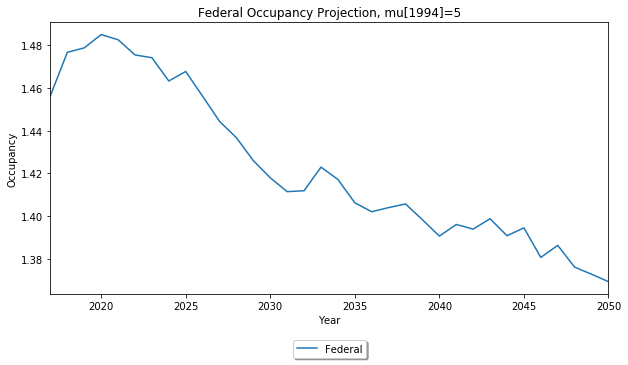

<Figure size 720x360 with 0 Axes>

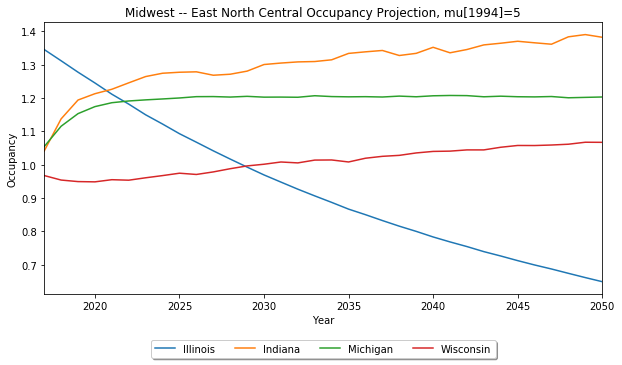

<Figure size 720x360 with 0 Axes>

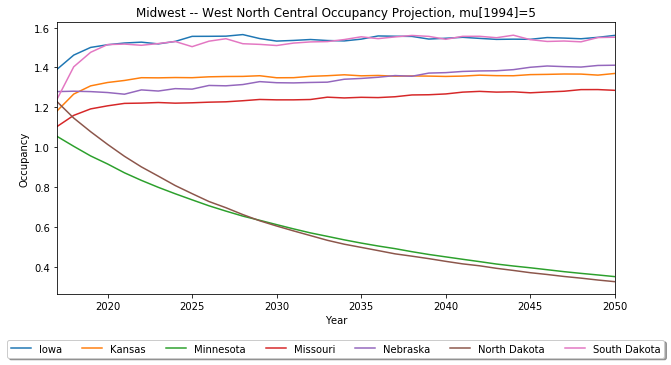

<Figure size 720x360 with 0 Axes>

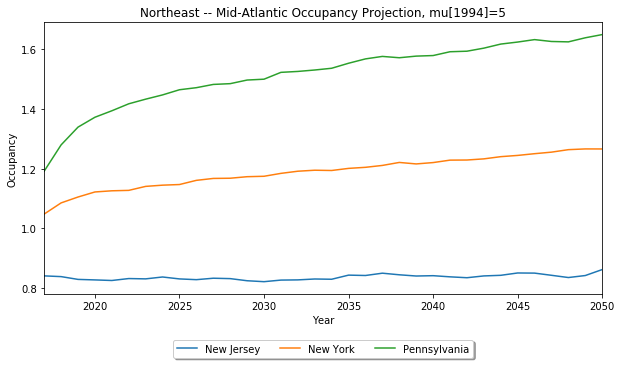

<Figure size 720x360 with 0 Axes>

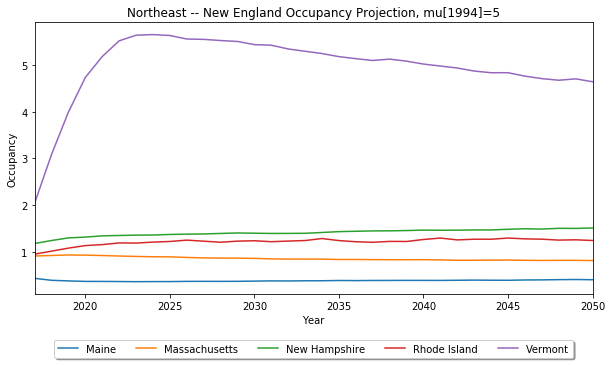

<Figure size 720x360 with 0 Axes>

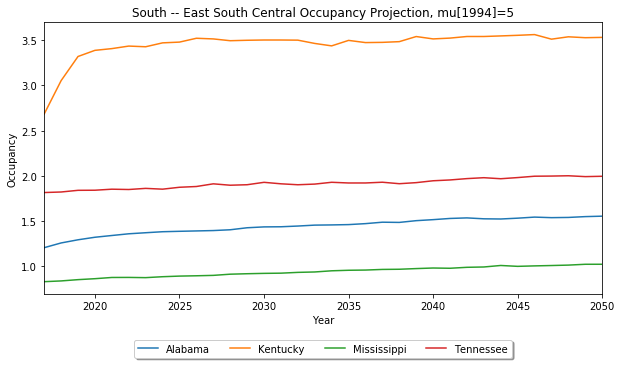

<Figure size 720x360 with 0 Axes>

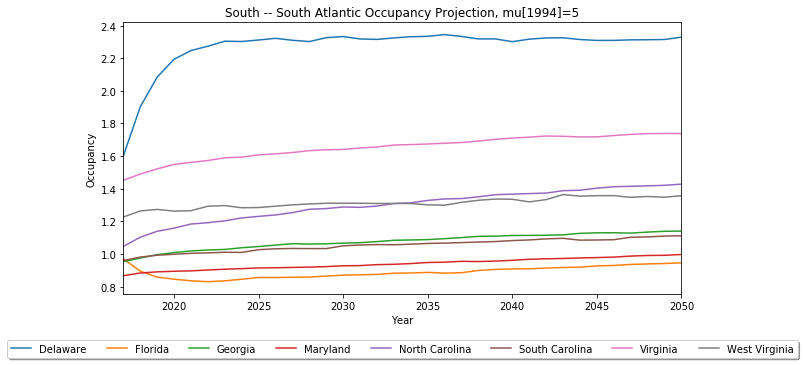

<Figure size 720x360 with 0 Axes>

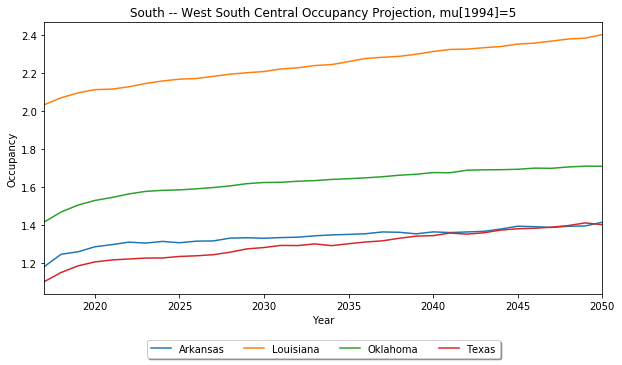

<Figure size 720x360 with 0 Axes>

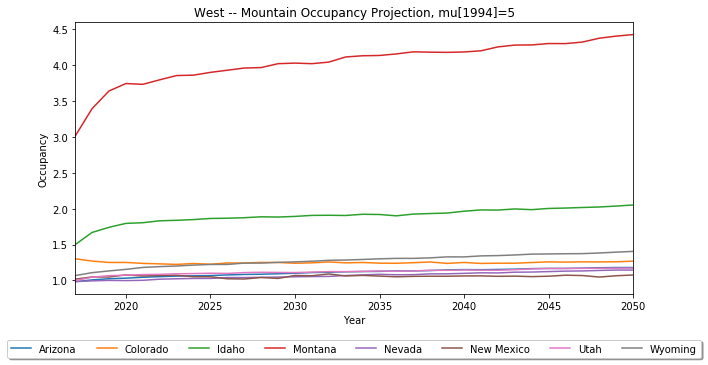

<Figure size 720x360 with 0 Axes>

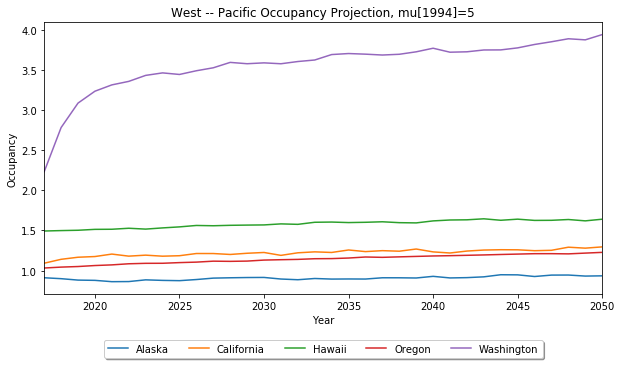

In [65]:
plotOccupancyProjection(futureOccupancyMean_5,futureOccupancySD_5, 5)
crossingupYear, crossingdownYear = checkOccupancyThresholdCrossing(futureOccupancies_5, 1.5,1, 5)

mu[1994] = 10
Year when occupancy rises above 1.5:
Delaware        2017
Kentucky        2017
Louisiana       2017
Montana         2017
Tennessee       2017
Vermont         2017
Washington      2017
Idaho           2018
Iowa            2020
South Dakota    2023
Virginia        2023
Oklahoma        2026
Pennsylvania    2039
Hawaii          2043
dtype: int64
Year when occupancy drops below 1:
Alaska            2017
South Carolina    2017
Rhode Island      2017
New Jersey        2017
Nevada            2017
Mississippi       2017
Utah              2017
Massachusetts     2017
Maine             2017
Indiana           2017
Georgia           2017
Florida           2017
Arizona           2017
Maryland          2017
Wisconsin         2017
Minnesota         2019
North Dakota      2021
Illinois          2031
dtype: int64


<Figure size 720x360 with 0 Axes>

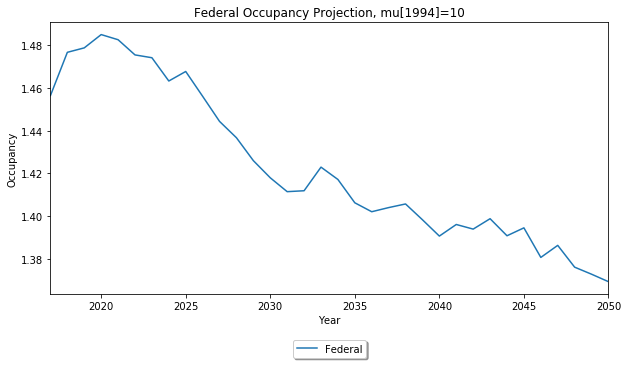

<Figure size 720x360 with 0 Axes>

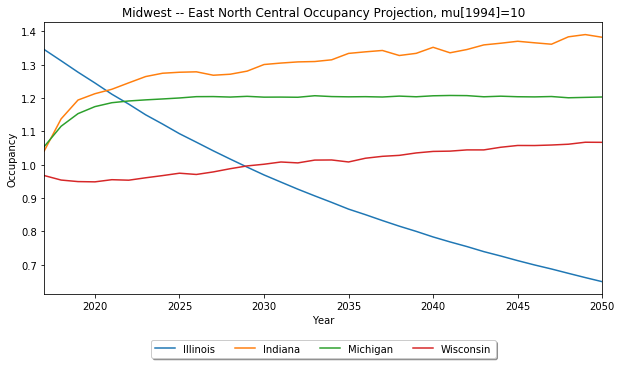

<Figure size 720x360 with 0 Axes>

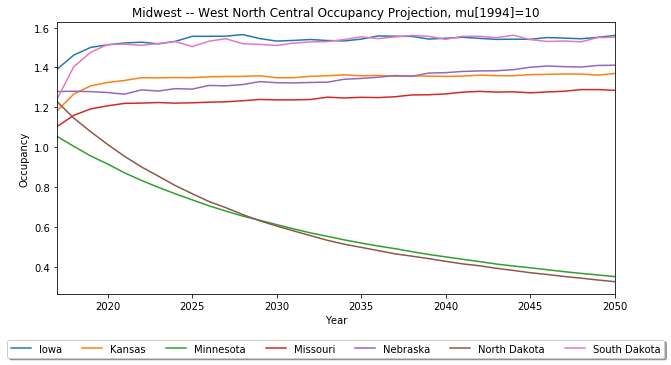

<Figure size 720x360 with 0 Axes>

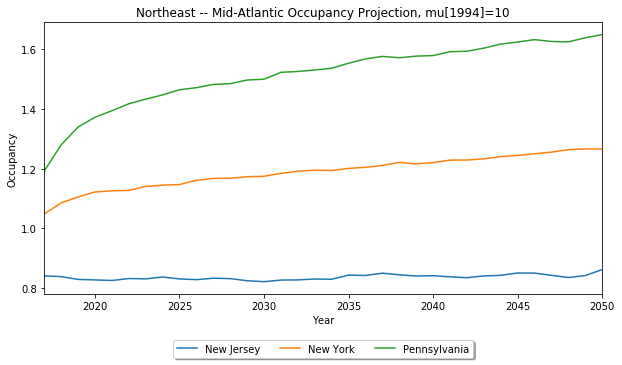

<Figure size 720x360 with 0 Axes>

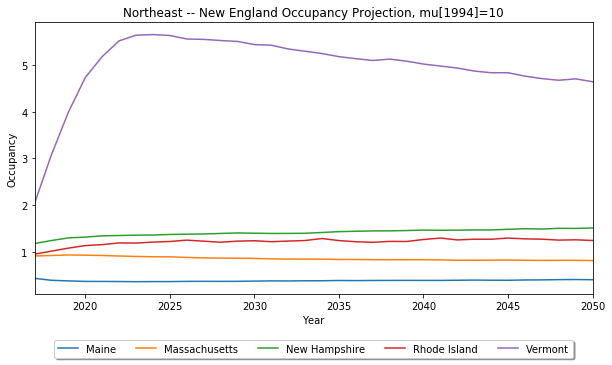

<Figure size 720x360 with 0 Axes>

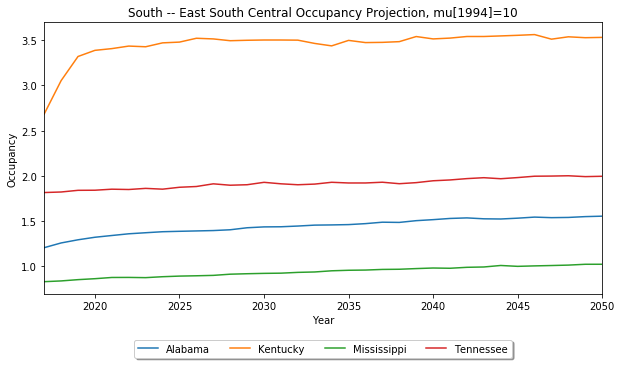

<Figure size 720x360 with 0 Axes>

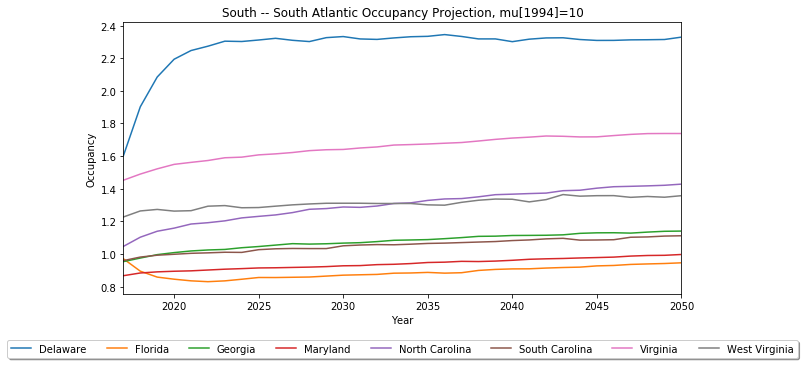

<Figure size 720x360 with 0 Axes>

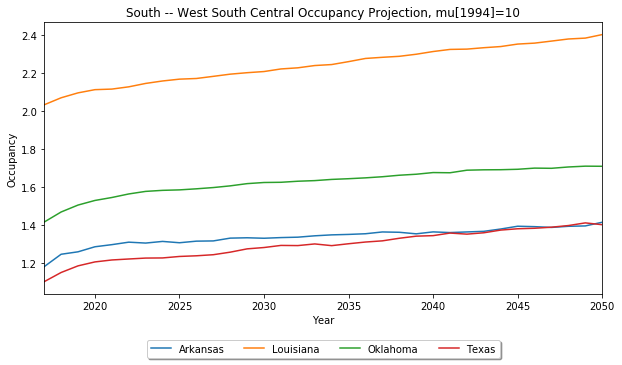

<Figure size 720x360 with 0 Axes>

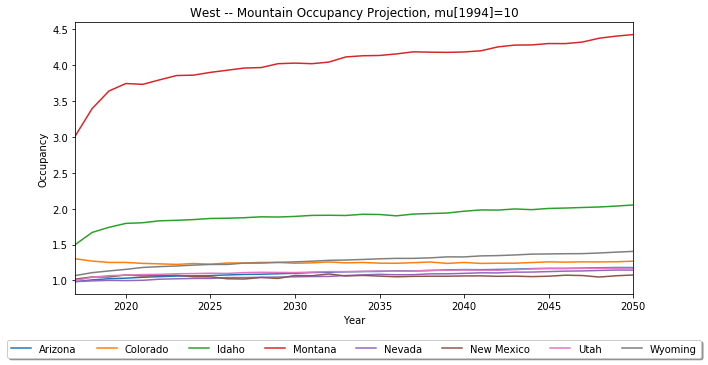

<Figure size 720x360 with 0 Axes>

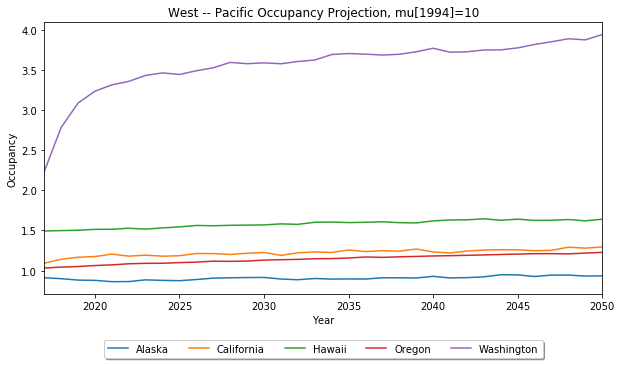

In [66]:
plotOccupancyProjection(futureOccupancyMean_10,futureOccupancySD_10, 10)
crossingupYear, crossingdownYear = checkOccupancyThresholdCrossing(futureOccupancies_10, 1.5,1, 10)

mu[1994] = 20
Year when occupancy rises above 1.5:
Kentucky        2017
Louisiana       2017
Montana         2017
Tennessee       2017
Vermont         2017
Washington      2017
Delaware        2018
Idaho           2018
Iowa            2022
South Dakota    2022
Virginia        2040
Oklahoma        2042
dtype: int64
Year when occupancy drops below 1:
Alaska            2017
South Carolina    2017
Rhode Island      2017
Oregon            2017
New Jersey        2017
Nevada            2017
Mississippi       2017
Utah              2017
Wisconsin         2017
Maryland          2017
Maine             2017
Indiana           2017
Georgia           2017
Florida           2017
Arizona           2017
Massachusetts     2017
Minnesota         2019
North Dakota      2021
Illinois          2032
dtype: int64


<Figure size 720x360 with 0 Axes>

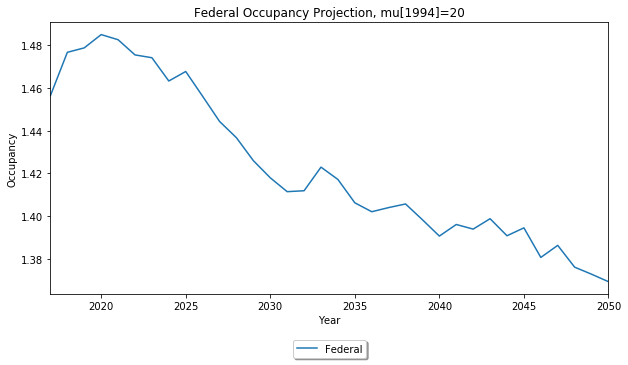

<Figure size 720x360 with 0 Axes>

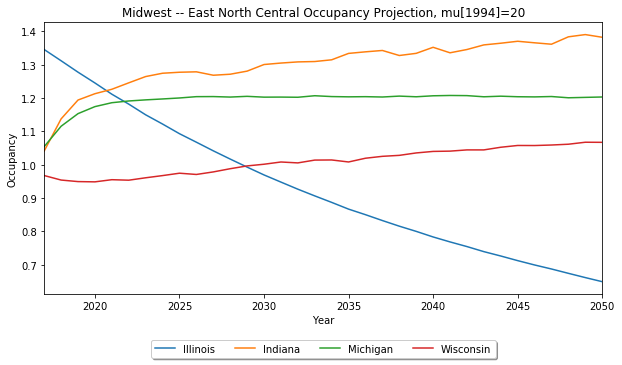

<Figure size 720x360 with 0 Axes>

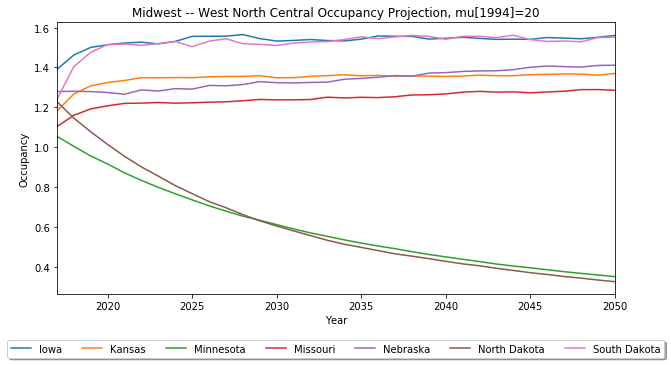

<Figure size 720x360 with 0 Axes>

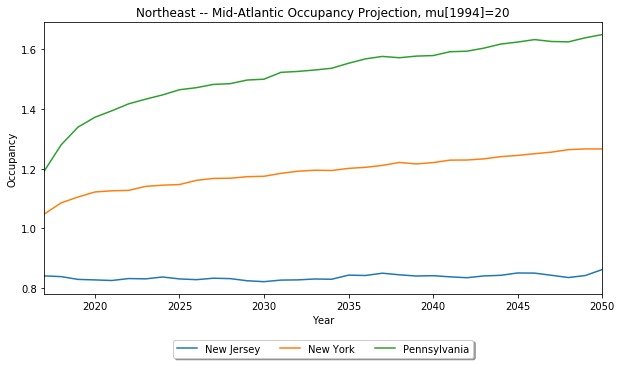

<Figure size 720x360 with 0 Axes>

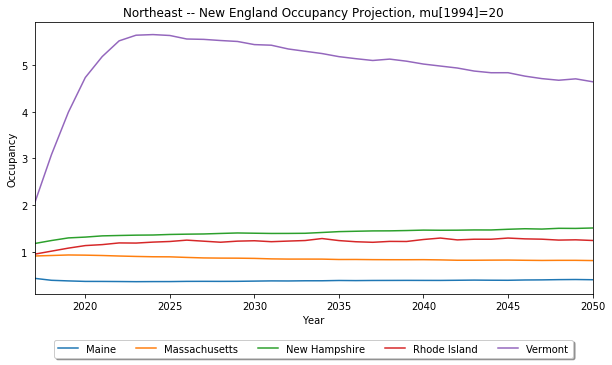

<Figure size 720x360 with 0 Axes>

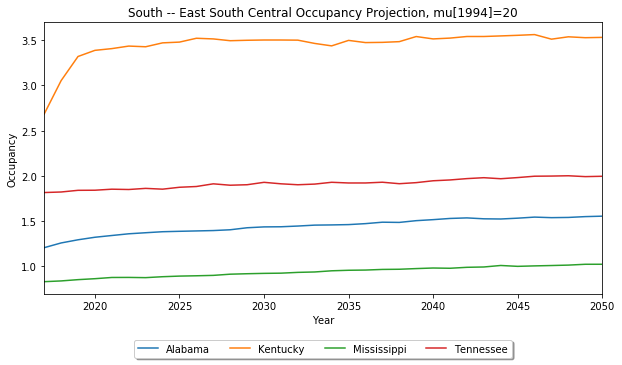

<Figure size 720x360 with 0 Axes>

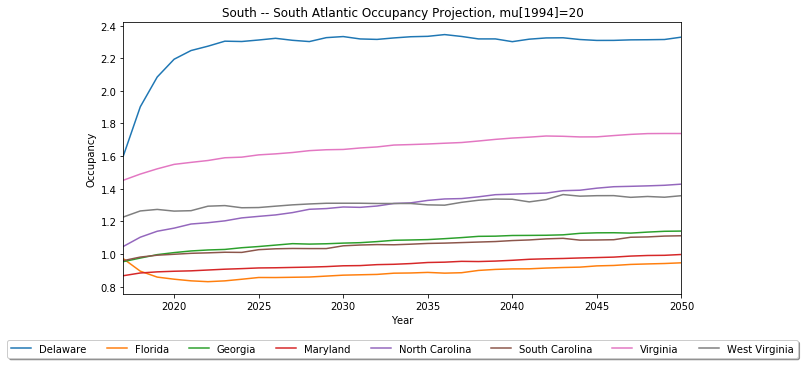

<Figure size 720x360 with 0 Axes>

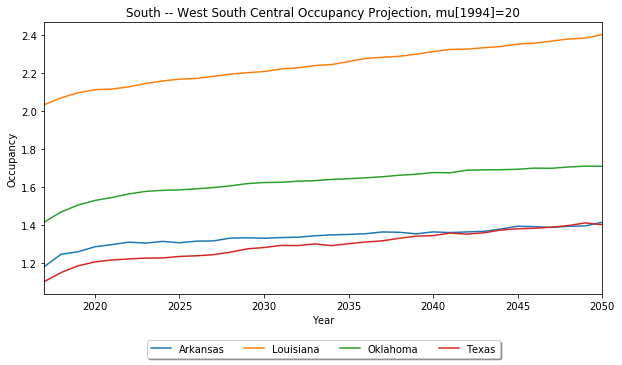

<Figure size 720x360 with 0 Axes>

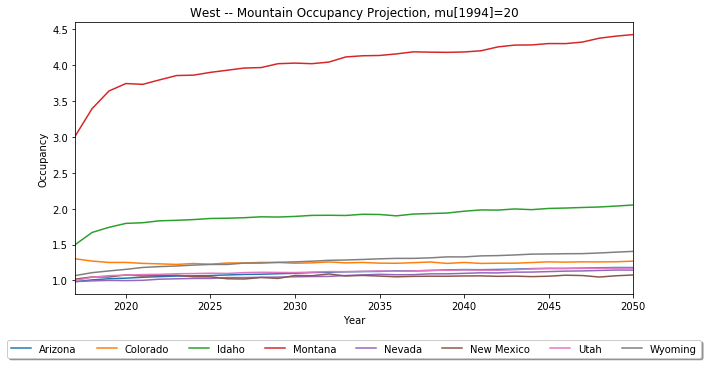

<Figure size 720x360 with 0 Axes>

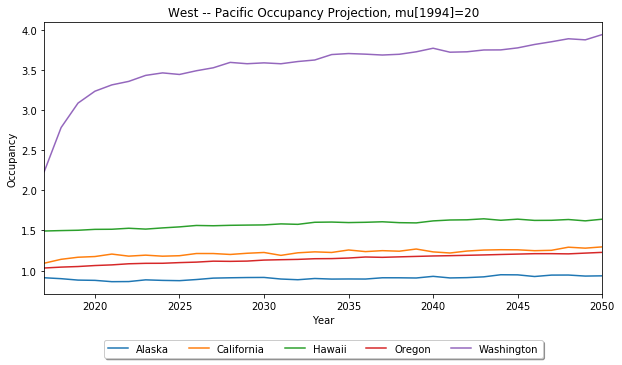

In [67]:
plotOccupancyProjection(futureOccupancyMean_20,futureOccupancySD_20, 20)
crossingupYear, crossingdownYear = checkOccupancyThresholdCrossing(futureOccupancies_20, 1.5,1, 20)

mu[1994] = 40
Year when occupancy rises above 1.5:
Kentucky        2017
Louisiana       2017
Montana         2017
Tennessee       2017
Vermont         2017
Washington      2017
Delaware        2018
Idaho           2018
Iowa            2022
South Dakota    2022
Virginia        2040
Oklahoma        2042
dtype: int64
Year when occupancy drops below 1:
Alaska            2017
South Carolina    2017
Rhode Island      2017
Oregon            2017
New Jersey        2017
Nevada            2017
Mississippi       2017
Utah              2017
Wisconsin         2017
Maryland          2017
Maine             2017
Indiana           2017
Georgia           2017
Florida           2017
Arizona           2017
Massachusetts     2017
Minnesota         2019
North Dakota      2021
Illinois          2032
dtype: int64


<Figure size 720x360 with 0 Axes>

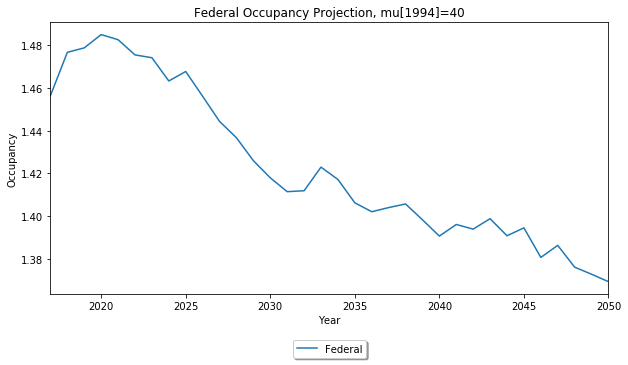

<Figure size 720x360 with 0 Axes>

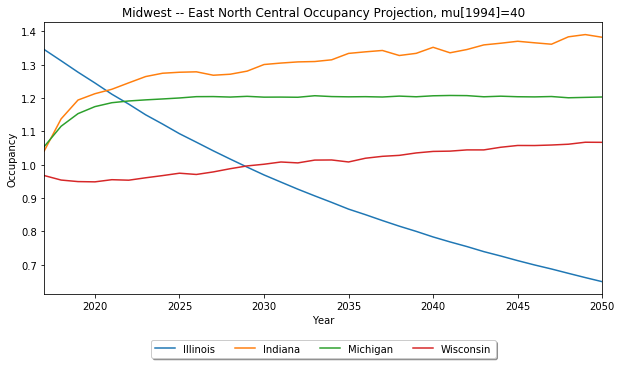

<Figure size 720x360 with 0 Axes>

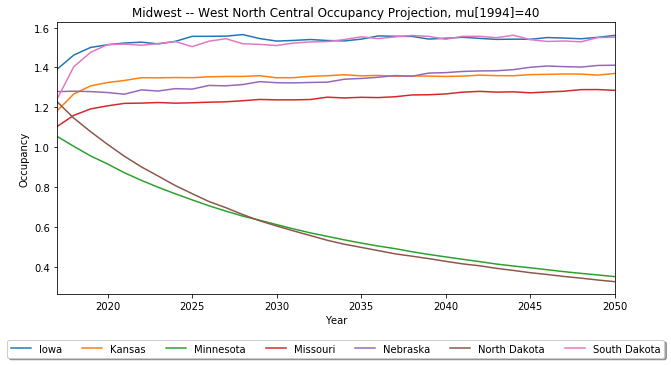

<Figure size 720x360 with 0 Axes>

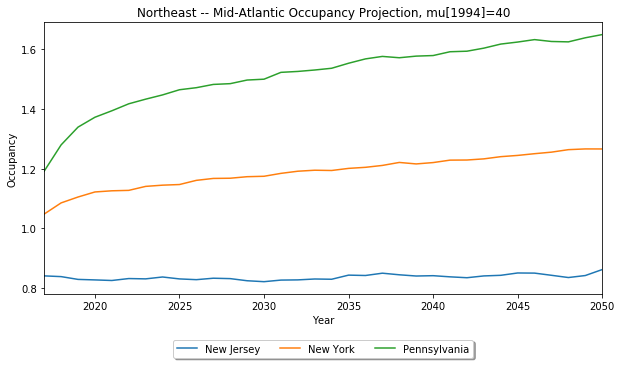

<Figure size 720x360 with 0 Axes>

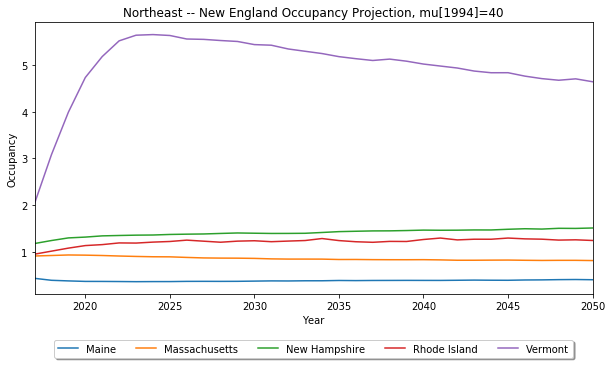

<Figure size 720x360 with 0 Axes>

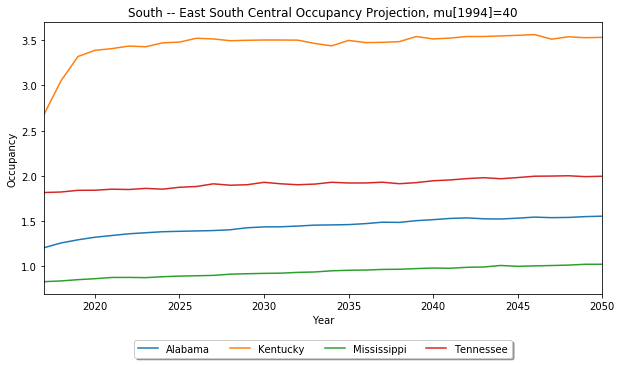

<Figure size 720x360 with 0 Axes>

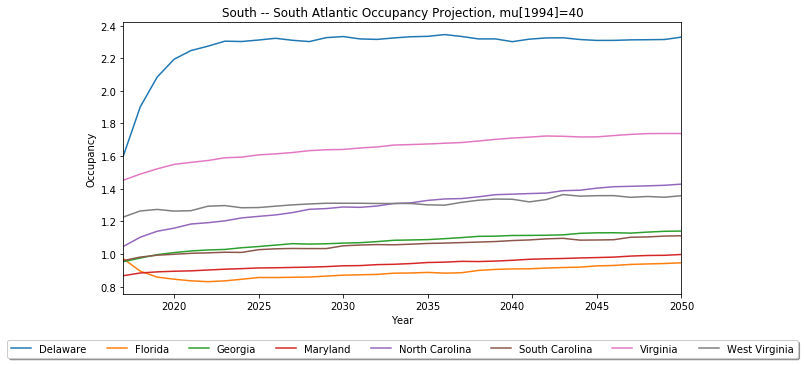

<Figure size 720x360 with 0 Axes>

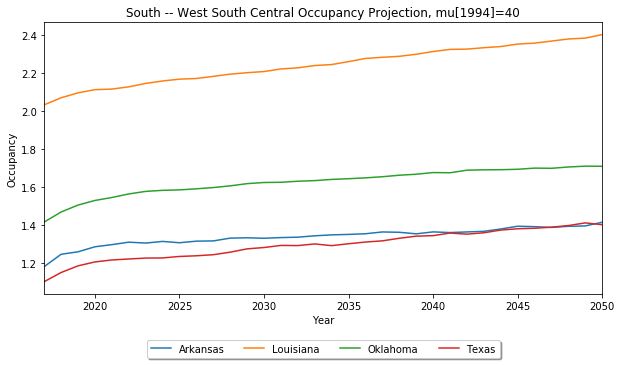

<Figure size 720x360 with 0 Axes>

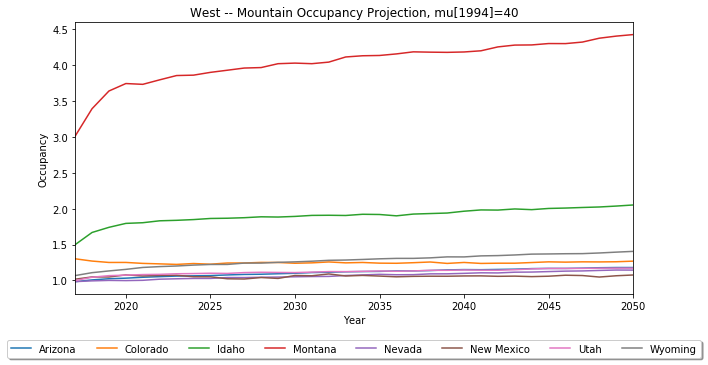

<Figure size 720x360 with 0 Axes>

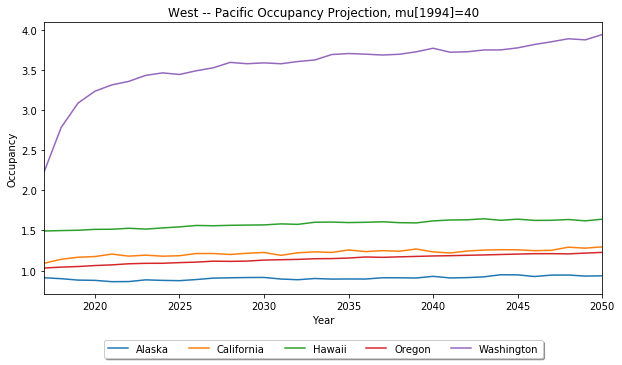

In [68]:
plotOccupancyProjection(futureOccupancyMean_20,futureOccupancySD_40, 40)
crossingupYear, crossingdownYear = checkOccupancyThresholdCrossing(futureOccupancies_20, 1.5,1, 40)